In [1]:
###############################################################################
# Import packages
###############################################################################
import os
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import gurobipy as gp
from gurobipy import GRB
from scipy.stats import skew
import math
import itertools
os.environ["OMP_NUM_THREADS"] = '1' # Prevent warning message of kmeans
import mglearn
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Load functions
from helperfunctions_data_generation import generate_random_tsp_instance
from helperfunctions_data_generation import solve_tsp
from helperfunctions_data_generation import fun_multi_dbscan, fun_cluster_features

# Function to compute the density of a cluster
def cluster_density(X, assignments):

    # Iterate over each cluster
    densities = {}
    labels = np.unique(assignments)

    for label in labels:
        # Get coordinates of the customers belonging to the cluster
        X_cluster = np.array(X)[assignments == label]

        # Compute density only if cluster size (number of customers) is greater than 1 and not for the label -1 (outlier)
        if (len(X_cluster) > 1) and (label != -1):            
            # Calculate the area of the cluster assuming it as circular
            min_x, min_y = np.min(X_cluster, axis=0)
            max_x, max_y = np.max(X_cluster, axis=0)
            diameter = max(max_x - min_x, max_y - min_y)

            # Calculate cluster density and add it into the dictionary
            area = np.pi * (diameter / 2) ** 2 # Formula for the area of a circle
            density = len(X_cluster) / area # Formula for the density
            densities[label] = density

        # The density of all outliers (label -1) or a cluster including only one customer is one
        else: densities[label] = 1

    return densities, area

**Plot functions**

In [2]:
# Function to visualize TSP and the optimal solution; additionally you can view cluster assignments of the corresponding model (k-Means, Agglomerative-Clustering, DBSCAN)
def plot_tsp(coord, sequence, total_costs, x_range, y_range, model=None, assignments=None, core_point_indices=None, plot_sequence=True, print_sequence=False):

    if (print_sequence == True): print('Optimal solution:', sequence)

    # Depot_coord: tuple with depot X and Y coordinate
    depot_coord = coord[0]

    # Customer_coord: list of tuples with all customers X and Y coordinates; x_coord: list with X coordinates of customers; y_coord: list with Y coordinates of customers
    customer_coord = coord[1:]
    x_coord = np.array([i[0] for i in np.array(customer_coord)])
    y_coord = np.array([i[1] for i in np.array(customer_coord)])

    # Add optimal route with arrows between origin and destination in sequence
    if (plot_sequence == True):
        for trip in sequence:
            origin = trip[0]
            destination = trip[1]
            x = coord[origin][0]
            y = coord[origin][1]
            dx = coord[destination][0] - coord[origin][0]
            dy = coord[destination][1] - coord[origin][1]
            plt.arrow(x=x, y=y, dx=dx, dy=dy,
                    head_width=2, head_length=3, fc='silver', ec='silver', length_includes_head=True)

    # Create scatter plot with depot (black) and customers (blue)
    plt.scatter(x=depot_coord[0], y=depot_coord[1], color='black', label='Depot', marker='s', s=50)
    if (model is None) & (assignments is None):
        plt.scatter(x=x_coord, y=y_coord, color='blue', label='Customers', marker='o', s=25)
    
    # Get cluster assignments if parameter 'model' is defined, but not parameter 'assignments'
    if (model is not None) & (assignments is None): assignments = model.labels_

    # Plot customers according to their cluster assignments if parameter 'assignments' is defined
    if (assignments is not None):

        # Get number of clusters and plot customers according to their cluster assignments
        K = len(np.unique(assignments))
        mglearn.discrete_scatter(x1=x_coord, x2=y_coord, y=assignments, markers='o')
        cluster_labels = ['Cluster ' + str(int(i)) for i in np.unique(assignments)]

        # DBSCAN: Mark core points in the plot if the parameter 'core_point_indices' is defined
        if (core_point_indices is not None):

            # Get indices of core points
            core_points_mask = np.zeros_like(assignments, dtype=bool) # Create list with same length as assignments containing only zero/False values
            core_points_mask[core_point_indices] = True # Set core point indices to one/True

            # Mark core points with a dot and add a label as clarification in the legend
            mglearn.discrete_scatter(x1=x_coord[core_points_mask], x2=y_coord[core_points_mask], y=assignments[core_points_mask], markers='.', s=5, c='k')
            last_legend_label = ['Core point']

        # k-Means: Add cluster centroids as triangle if the model has the attribute 'cluster_centers_' and add a label as clarification in the legend
        elif (hasattr(model, 'cluster_centers_')):
            mglearn.discrete_scatter(x1=model.cluster_centers_[:, 0], x2=model.cluster_centers_[:, 1], y=np.arange(0, K), markers='^', s=10, markeredgewidth=2)
            last_legend_label = ['Centroid']

        # Agglormerative-Clustering: omit the last label for the legend
        else: last_legend_label = [None]
    else:
        cluster_labels = ['Customers']
        last_legend_label = [None]

    # Add annotations to identify the customers
    for i in range(len(customer_coord)):
        plt.annotate(text='C' + str(i+1), xy=(x_coord[i], y_coord[i]), textcoords='offset points', xytext=(0, 5), ha='center')

    plt.title('Traveling Salesman Problem: Total costs: ' + str(int(total_costs)), size=16)
    plt.xlabel('X', fontweight='bold')
    plt.ylabel('Y', fontweight='bold')
    plt.xticks(range(0, x_range[1] + 10, int(x_range[1]/10))) # Adjust x ticks dynamically to the given x_range
    plt.yticks(range(0, y_range[1] + 10, int(x_range[1]/10))) # Adjust y ticks dynamically to the given y_range
    plt.grid(True)

    # Get unique labels and set legend labels dynamically
    legend_labels = ['Depot'] + cluster_labels + last_legend_label
    
    # Get handles and labels from all scatter plots and create the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, legend_labels, loc='best', bbox_to_anchor=(1.05, 1.0))
    plt.show()

In [3]:
# Function to visualize a TSP in subplots with the corresponding cluster assignments of the models k-Means, Agglomerative-Clustering or DBSCAN
def plot_clusters(coord, x_range, y_range, ax, model=None, score=None, assignments=None, core_point_indices=None, instance_id=None):

    # Depot_coord: tuple with depot X and Y coordinate
    depot_coord = coord[0]

    # Customer_coord: list of tuples with all customers X and Y coordinates; x_coord: list with X coordinates of customers; y_coord: list with Y coordinates of customers
    customer_coord = coord[1:]
    x_coord = np.array([i[0] for i in np.array(customer_coord)])
    y_coord = np.array([i[1] for i in np.array(customer_coord)])

    # Create scatter plot with the depot (black)
    ax.scatter(x=depot_coord[0], y=depot_coord[1], color='black', label='Depot', marker='s', s=50)

    # Get cluster assignments if parameter 'model' is defined, but not parameter 'assignments'
    if (model is not None) & (assignments is None): assignments = model.labels_
    
    # Get number of clusters and plot customers according to their cluster assignments
    K = len(np.unique(assignments))
    mglearn.discrete_scatter(x1=x_coord, x2=y_coord, y=assignments, markers='o', ax=ax)

    # DBSCAN: Mark core points in the plot if the parameter 'core_point_indices' is defined
    if (core_point_indices is not None):

        # Get indices of core points
        core_points_mask = np.zeros_like(assignments, dtype=bool) # Create list with same length as assignments containing only zero/False values
        core_points_mask[core_point_indices] = True # Set core point indices to one/True

        # Mark core points with a dot and add a label as clarification in the legend
        mglearn.discrete_scatter(x1=x_coord[core_points_mask], x2=y_coord[core_points_mask], y=assignments[core_points_mask], markers='.', s=5, c='k', ax=ax)
        last_legend_label = ['Core point']

    # k-Means: Add cluster centroids as triangle if the model has the attribute 'cluster_centers_' and add a label as clarification in the legend
    elif (hasattr(model, 'cluster_centers_')):
        mglearn.discrete_scatter(x1=model.cluster_centers_[:, 0], x2=model.cluster_centers_[:, 1], y=np.arange(0, K), markers='^', s=10, markeredgewidth=2, ax=ax)
        last_legend_label = ['Centroid']

    # Agglormerative-Clustering: omit the last label for the legend
    else: last_legend_label = [None]
    
    # Add annotations to identify the customers
    for i in range(len(customer_coord)):
        ax.annotate(text='C' + str(i+1), xy=(x_coord[i], y_coord[i]), textcoords='offset points', xytext=(0, 5), ha='center')

    # Modify the subplot title depending on the input
    if (score is not None): ax.set_title('TSP with {} clusters and Silhouette score {}'.format(K, np.round(score, 4)), size=16) # k-Means
    else: ax.set_title('Instance ID: {} - TSP with {} customers'.format(instance_id, len(customer_coord)), size=16) # DBSCAN
    ax.set_xlabel('X', fontweight='bold')
    ax.set_ylabel('Y', fontweight='bold')
    ax.set_xticks(range(0, x_range[1] + 10, int(x_range[1]/10))) # Adjust x ticks dynamically to the given x_range
    ax.set_yticks(range(0, y_range[1] + 10, int(x_range[1]/10))) # Adjust y ticks dynamically to the given y_range
    ax.grid(True)

    # Get unique labels and set legend labels dynamically
    legend_labels = ['Depot'] + ['Cluster ' + str(i) for i in np.unique(assignments)] + last_legend_label

    # Create legend with the labels
    ax.legend(legend_labels, loc='best')

# **k-Means-Clustering**
**Plot a TSP instance with a specific number of clusters**

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-04


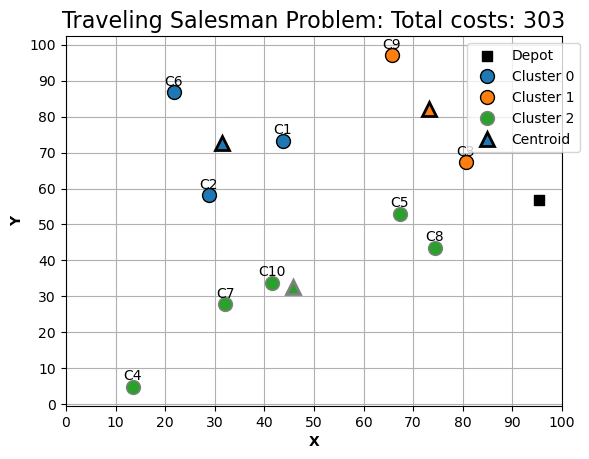

In [4]:
# Create TSP instance
x_range=(0, 100)
y_range=(0, 100)
tsp_instance = generate_random_tsp_instance(num_customers=10, x_range=x_range, y_range=x_range)

# Extract X and Y coordinates of depot and all customers (first two columns) as tuples and give it as input for function solve_tsp
coord = [(tsp_instance['X'][i], tsp_instance['Y'][i]) for i in range(len(tsp_instance))]

# Solve TSP and receive sequence (optimal tour) and total costs as output
sequence, total_costs  = solve_tsp(coord)

# Get customer data
X = coord[1:] # exclude depot!!

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
kmeans.fit(X)

# View clusters
plot_tsp(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, model=kmeans, plot_sequence=False)

**Plot a TSP instance with different values for k (number of clusters)**

Best k: 3

Best k: 5

Best k: 6

Number of clusters: 2; Cluster densities: {0: 0.0016, 1: 0.0027}
Number of clusters: 3; Cluster densities: {0: 0.0033, 1: 0.0055, 2: 0.0062}
Number of clusters: 4; Cluster densities: {0: 0.0046, 1: 0.0037, 2: 0.0122, 3: 0.0033}
Number of clusters: 5; Cluster densities: {0: 1, 1: 0.0055, 2: 0.0122, 3: 0.0033, 4: 0.0198}
Number of clusters: 6; Cluster densities: {0: 1, 1: 0.0055, 2: 0.0122, 3: 0.3416, 4: 0.0198, 5: 1}
Number of clusters: 7; Cluster densities: {0: 1, 1: 0.0067, 2: 0.0122, 3: 0.3416, 4: 0.0198, 5: 1, 6: 1}


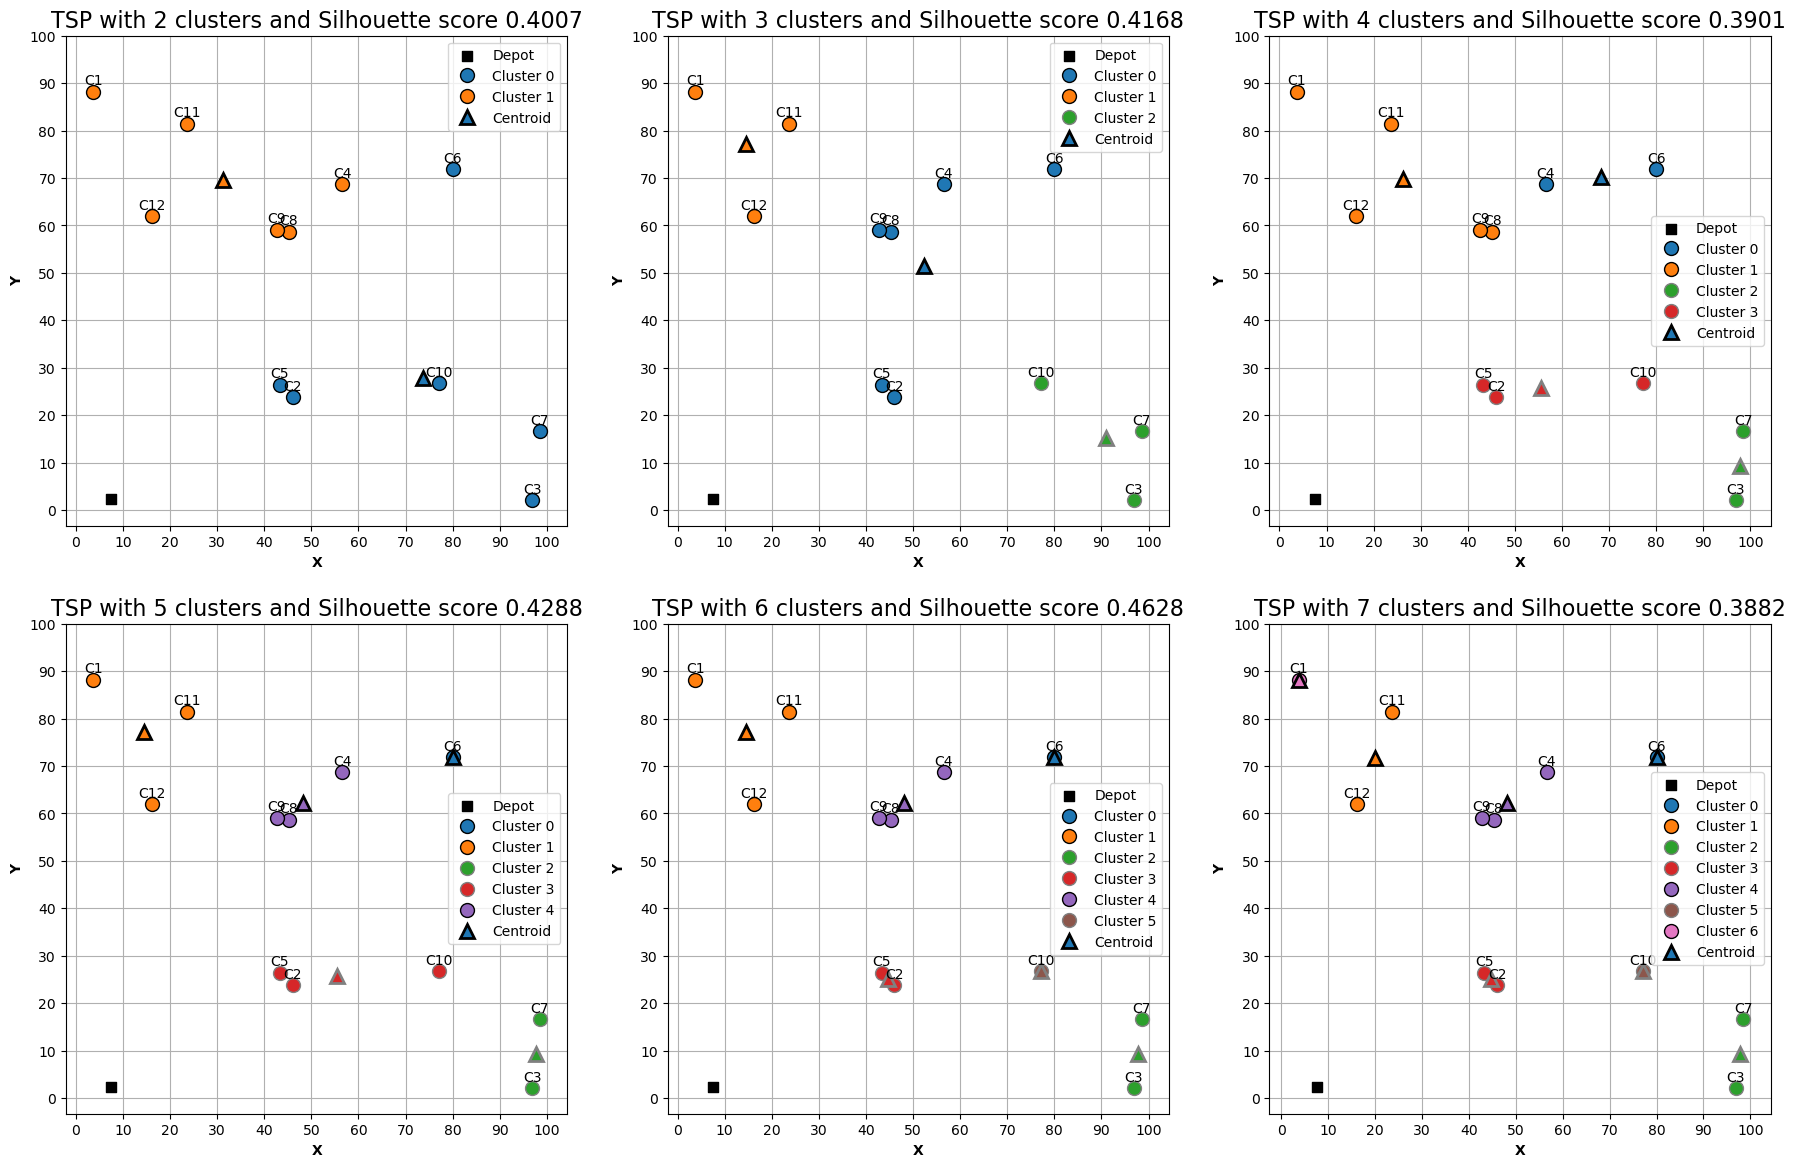

In [5]:
from sklearn.metrics.cluster import silhouette_score

# Create TSP instance and get coordinates
num_customers = 12
tsp_instance = generate_random_tsp_instance(num_customers=num_customers, x_range=x_range, y_range=x_range)
coord = [(tsp_instance['X'][i], tsp_instance['Y'][i]) for i in range(len(tsp_instance))]
X = coord[1:]

# Define parameters and create two dictionaries to store the silhoutte score of the clustering and the density of each single cluster
rows = 2
columns = 3
k = 2 # Number of minimum clusters
best_score = 0
scores = {}
densities = {}

# Create subplots
fig, axs = plt.subplots(rows, columns, figsize=(22, 14))

for i in range(rows):
    for j in range(columns):
        # Train k-Means model
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
        kmeans.fit(X)

        # Compute the silhoutte score of the clustering
        score = silhouette_score(X, kmeans.labels_)
        scores[str(k) + ' clusters'] = score

        # Compute the density of all clusters
        density_values, area = cluster_density(X=X, assignments=kmeans.labels_)
        densities[k] = density_values

        # Update best_score if the least dense cluster has a minimum density of 0.0025 and the silhoutte score is higher than the current best_score
        min_density = min(density_values.values())
        if (min_density >= 0.0025) & (score > best_score):
            best_score = score
            best_k = k
            print('Best k: {}\n'.format(best_k))

        # View clusters of current k in the subplots
        plot_clusters(coord=coord, x_range=x_range, y_range=y_range, ax=axs[i, j], model=kmeans, score=score)
        k += 1

# Print cluster densities
for keys, values in densities.items():
    print('Number of clusters: {}; Cluster densities: {}'.format(keys, {key: np.round(values[key], 4) for key in values.keys()}))

# **Agglomerative Clustering**
**Plot a TSP instance with different values for k (number of clusters)**

Best k: 6

Number of clusters: 2; Cluster densities: {0: 0.001, 1: 0.0022}
Number of clusters: 3; Cluster densities: {0: 0.0022, 1: 0.0032, 2: 0.0072}
Number of clusters: 4; Cluster densities: {0: 0.0032, 1: 0.0022, 2: 0.0072, 3: 0.0039}
Number of clusters: 5; Cluster densities: {0: 0.0022, 1: 0.0039, 2: 0.0072, 3: 0.005, 4: 0.0074}
Number of clusters: 6; Cluster densities: {0: 0.0039, 1: 0.005, 2: 0.0072, 3: 0.0222, 4: 0.0074, 5: 1}
Number of clusters: 7; Cluster densities: {0: 0.005, 1: 0.0074, 2: 0.0072, 3: 0.0222, 4: 0.0531, 5: 1, 6: 1}


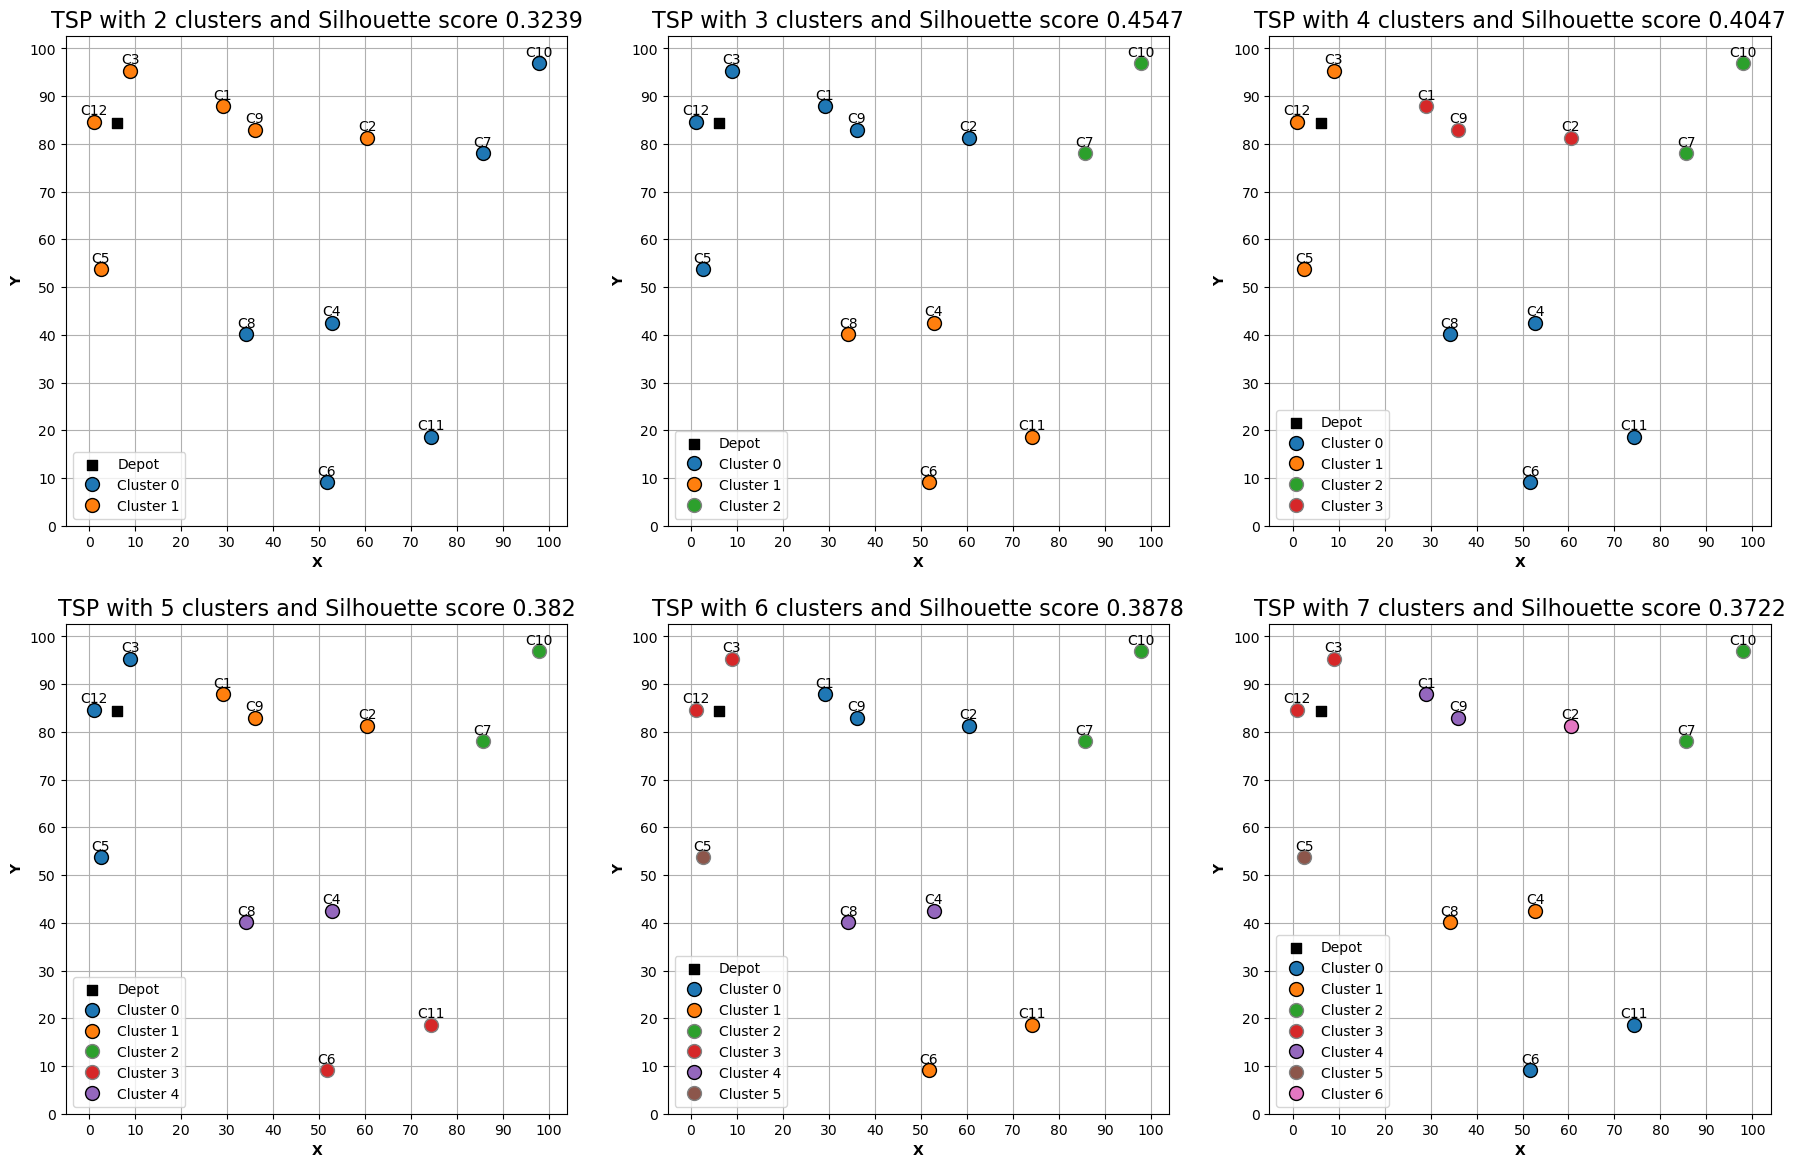

In [6]:
# Create TSP instance and get coordinates
num_customers = 12
tsp_instance = generate_random_tsp_instance(num_customers=num_customers, x_range=x_range, y_range=x_range)
coord = [(tsp_instance['X'][i], tsp_instance['Y'][i]) for i in range(len(tsp_instance))]
X = coord[1:]

# Define parameters and create two dictionaries to store the silhoutte score and the density of each cluster
rows = 2
columns = 3
k = 2 # Number of clusters
best_score = 0
scores = {}
densities = {}

# Create subplots
fig, axs = plt.subplots(rows, columns, figsize=(22, 14))

for i in range(rows):
    for j in range(columns):
        # Train agglomerative model
        agg = AgglomerativeClustering(n_clusters=k)
        agg.fit(X)

        # Compute the silhoutte score of the clustering
        score = silhouette_score(X, agg.labels_)
        scores[str(k) + ' clusters'] = score

        # Compute the density of all clusters
        density_values, area = cluster_density(X=X, assignments=agg.labels_)
        densities[k] = density_values

        # Update best_score if the least dense cluster has a minimum density of 0.0025 and the silhoutte score is higher than the current best_score
        min_density = min(density_values.values())
        if (min_density >= 0.0025) & (score > best_score):
            best_score = score
            best_k = k
            print('Best k: {}\n'.format(best_k))

        # View clusters of current k in the subplots
        plot_clusters(coord=coord, x_range=x_range, y_range=y_range, ax=axs[i, j], model=agg, score=score)
        k += 1

# Print cluster densities
for keys, values in densities.items():
    print('Number of clusters: {}; Cluster densities: {}'.format(keys, {key: np.round(values[key], 4) for key in values.keys()}))

# **DBSCAN**
### **Multi-DBSCAN approach**
1. **Try to find denser clusters with at least three customers** <br> [e.g. num_customers=7: (eps, min_samples) = (33, 3)] -> At least 3 points within Euclidean distance 33 required to be defined as a core point
2. **Try to find less dense clusters with at least two customers** <br> [e.g. num_customers=7: (eps, min_samples) = (40, 2)]
3. **Try to connect the remaining customers with higher distance** <br> [e.g. num_customers=7: (eps, min_samples) = (55, 2)]
4. **The still remaining customers are classified as outliers** <br> [label: -1]

Note: The distances (parameter 'eps') decrease approximately linearly as the number of customers (instance size) increases.


############### CLUSTER FEATURES ###############
- Min cluster size: 3 with 30 eps
  labels: [1 1 0 0 0 0 0 0 0 1]
  Core points: [ 3  5  6  9 10]
-> No outliers left!


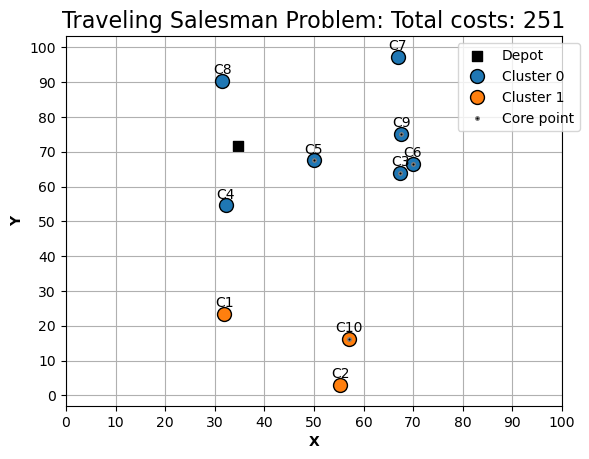

Cluster densities: {0: 0.0049, 1: 0.006}


,1,2,3,4,5,6,7,8,9,10
1,0.000000,31.031912,53.936614,31.180979,47.667738,57.409553,81.668137,67.007821,62.869935,26.211904
2,31.031912,0.000000,62.164885,56.467362,64.706329,65.070800,94.883149,90.568626,73.150322,13.387058
3,53.936614,62.164885,0.000000,36.380539,17.788613,3.482450,33.203824,44.577960,11.131102,48.807853
4,31.180979,56.467362,36.380539,0.000000,21.921245,39.450196,54.901877,35.836170,40.900865,45.654073
5,47.667738,64.706329,17.788613,21.921245,0.000000,19.953239,34.165629,29.421164,19.235771,51.721409
6,57.409553,65.070800,3.482450,39.450196,19.953239,0.000000,30.908164,45.266459,8.979291,51.751190
7,81.668137,94.883149,33.203824,54.901877,34.165629,30.908164,0.000000,36.029277,22.083656,81.497693
8,67.007821,90.568626,44.577960,35.836170,29.421164,45.266459,36.029277,0.000000,39.235637,78.427744
9,62.869935,73.150322,11.131102,40.900865,19.235771,8.979291,22.083656,39.235637,0.000000,59.772039
10,26.211904,13.387058,48.807853,45.654073,51.721409,51.751190,81.497693,78.427744,59.772039,0.000000


In [7]:
# Generate a new TSP instance
num_customers = 10
create_new_instance = True # Set this parameter to False for investigating the current TSP instance

if (create_new_instance == True):
    tsp_instance = generate_random_tsp_instance(num_customers=num_customers, x_range=x_range, y_range=x_range)
    coord = [(tsp_instance['X'][i], tsp_instance['Y'][i]) for i in range(len(tsp_instance))]
    sequence, total_costs  = solve_tsp(coord)
    X = coord[1:]

# Clustering the customers of the TSP instance
assignments, core_point_indices = fun_multi_dbscan(X=X, num_customers=num_customers, prints=True)

# View clusters
plot_tsp(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
         assignments=assignments, core_point_indices=core_point_indices, plot_sequence=False)

# Compute cluster densities
densities, area = cluster_density(X=X, assignments=assignments)

# Print cluster densities and view customer distances matrix as data frame
print('Cluster densities: {}'.format({key: np.round(densities[key], 4) for key in np.sort(list(densities.keys()))}))
pd.DataFrame(cdist(tsp_instance.iloc[1:][['X', 'Y']], tsp_instance.iloc[1:][['X', 'Y']], metric='euclidean'), index=np.arange(1, num_customers+1), columns=np.arange(1, num_customers+1))

**Add cluster features to TSP instance**

In [8]:
# Get X and Y coordinate of the depot
x_depot = tsp_instance.loc[0, 'X'] # X coordinate of depot
y_depot = tsp_instance.loc[0, 'Y'] # Y coordinate of depot

# Calculate the distance between the depot and each location
tsp_instance['Depot Distance'] = np.sqrt((tsp_instance['X'] - x_depot) ** 2 + (tsp_instance['Y'] - y_depot) ** 2) # Euclidean distance
display(tsp_instance)

# Define columns for displaying tsp instance
instance_features = ['X', 'Y', 'Depot Distance']
cluster_features = ['Cluster', 'Core Point', 'Outlier', 'Number Clusters', 'Number Outliers', 'Cluster Size', 'X Centroid', 'Y Centroid', 'Centroid Distance', 
                    'Centroid Distance To Depot', 'Distance To Closest Other Cluster', 'Distance To Closest Other Centroid', 'Cluster Area', 'Cluster Density']

# Execute function for cluster features
tsp_instance = fun_cluster_features(data=tsp_instance, assignments=assignments, core_point_indices=core_point_indices, 
                                    features=instance_features+cluster_features, prints=True)

,X,Y,Depot Distance
0,34.730209,71.606277,0.000000
1,31.927106,23.385957,48.301725
2,55.342877,3.022233,71.614615
3,67.414423,64.003793,33.556753
4,32.279658,54.564943,17.216628
5,49.973859,67.505430,15.785621
6,69.898852,66.444095,35.545486
7,66.865853,97.203086,41.084015
8,31.486165,90.392327,19.064089
9,67.632819,75.132752,33.091053


  - Cluster: 0
      Centroid: {'X': 55.0788042831502, 'Y': 73.60663234923243}
      Distances to centroid: {'Customer 3': 15.632722680790556, 'Customer 4': 29.70499954874451, 'Customer 5': 7.955195210678955, 'Customer 6': 16.460126104901654, 'Customer 7': 26.376640002569903, 'Customer 8': 28.954657384333363, 'Customer 9': 12.64643518341882}
  - Cluster: 1
      Centroid: {'X': 48.142990111648565, 'Y': 14.23124032202096}
      Distances to centroid: {'Customer 1': 18.62159320085182, 'Customer 2': 13.322169702937334, 'Customer 10': 9.247070823870684}


,X,Y,Depot Distance,Cluster,Core Point,Outlier,Number Clusters,Number Outliers,Cluster Size,X Centroid,Y Centroid,Centroid Distance,Centroid Distance To Depot,Distance To Closest Other Cluster,Distance To Closest Other Centroid,Cluster Area,Cluster Density
0,34.730209,71.606277,0.000000,<NA>,<NA>,<NA>,2,0,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31.927106,23.385957,48.301725,1,0,0,2,0,3,48.142990,14.231240,18.621593,58.921962,31.180979,55.300248,500.022051,0.006000
2,55.342877,3.022233,71.614615,1,0,0,2,0,3,48.142990,14.231240,13.322170,58.921962,56.467362,70.584893,500.022051,0.006000
3,67.414423,64.003793,33.556753,0,1,0,2,0,7,55.078804,73.606632,15.632723,20.446681,48.807853,53.373169,1427.862692,0.004902
4,32.279658,54.564943,17.216628,0,0,0,2,0,7,55.078804,73.606632,29.705000,20.446681,31.180979,43.341122,1427.862692,0.004902
5,49.973859,67.505430,15.785621,0,1,0,2,0,7,55.078804,73.606632,7.955195,20.446681,47.667738,53.305641,1427.862692,0.004902
6,69.898852,66.444095,35.545486,0,1,0,2,0,7,55.078804,73.606632,16.460126,20.446681,51.751190,56.564120,1427.862692,0.004902
7,66.865853,97.203086,41.084015,0,0,0,2,0,7,55.078804,73.606632,26.376640,20.446681,81.497693,85.058055,1427.862692,0.004902
8,31.486165,90.392327,19.064089,0,0,0,2,0,7,55.078804,73.606632,28.954657,20.446681,67.007821,77.961279,1427.862692,0.004902
9,67.632819,75.132752,33.091053,0,1,0,2,0,7,55.078804,73.606632,12.646435,20.446681,59.772039,63.944097,1427.862692,0.004902


# **Multi-DBSCAN**
**Apply Multi-DBSCAN on all cutomer sizes**

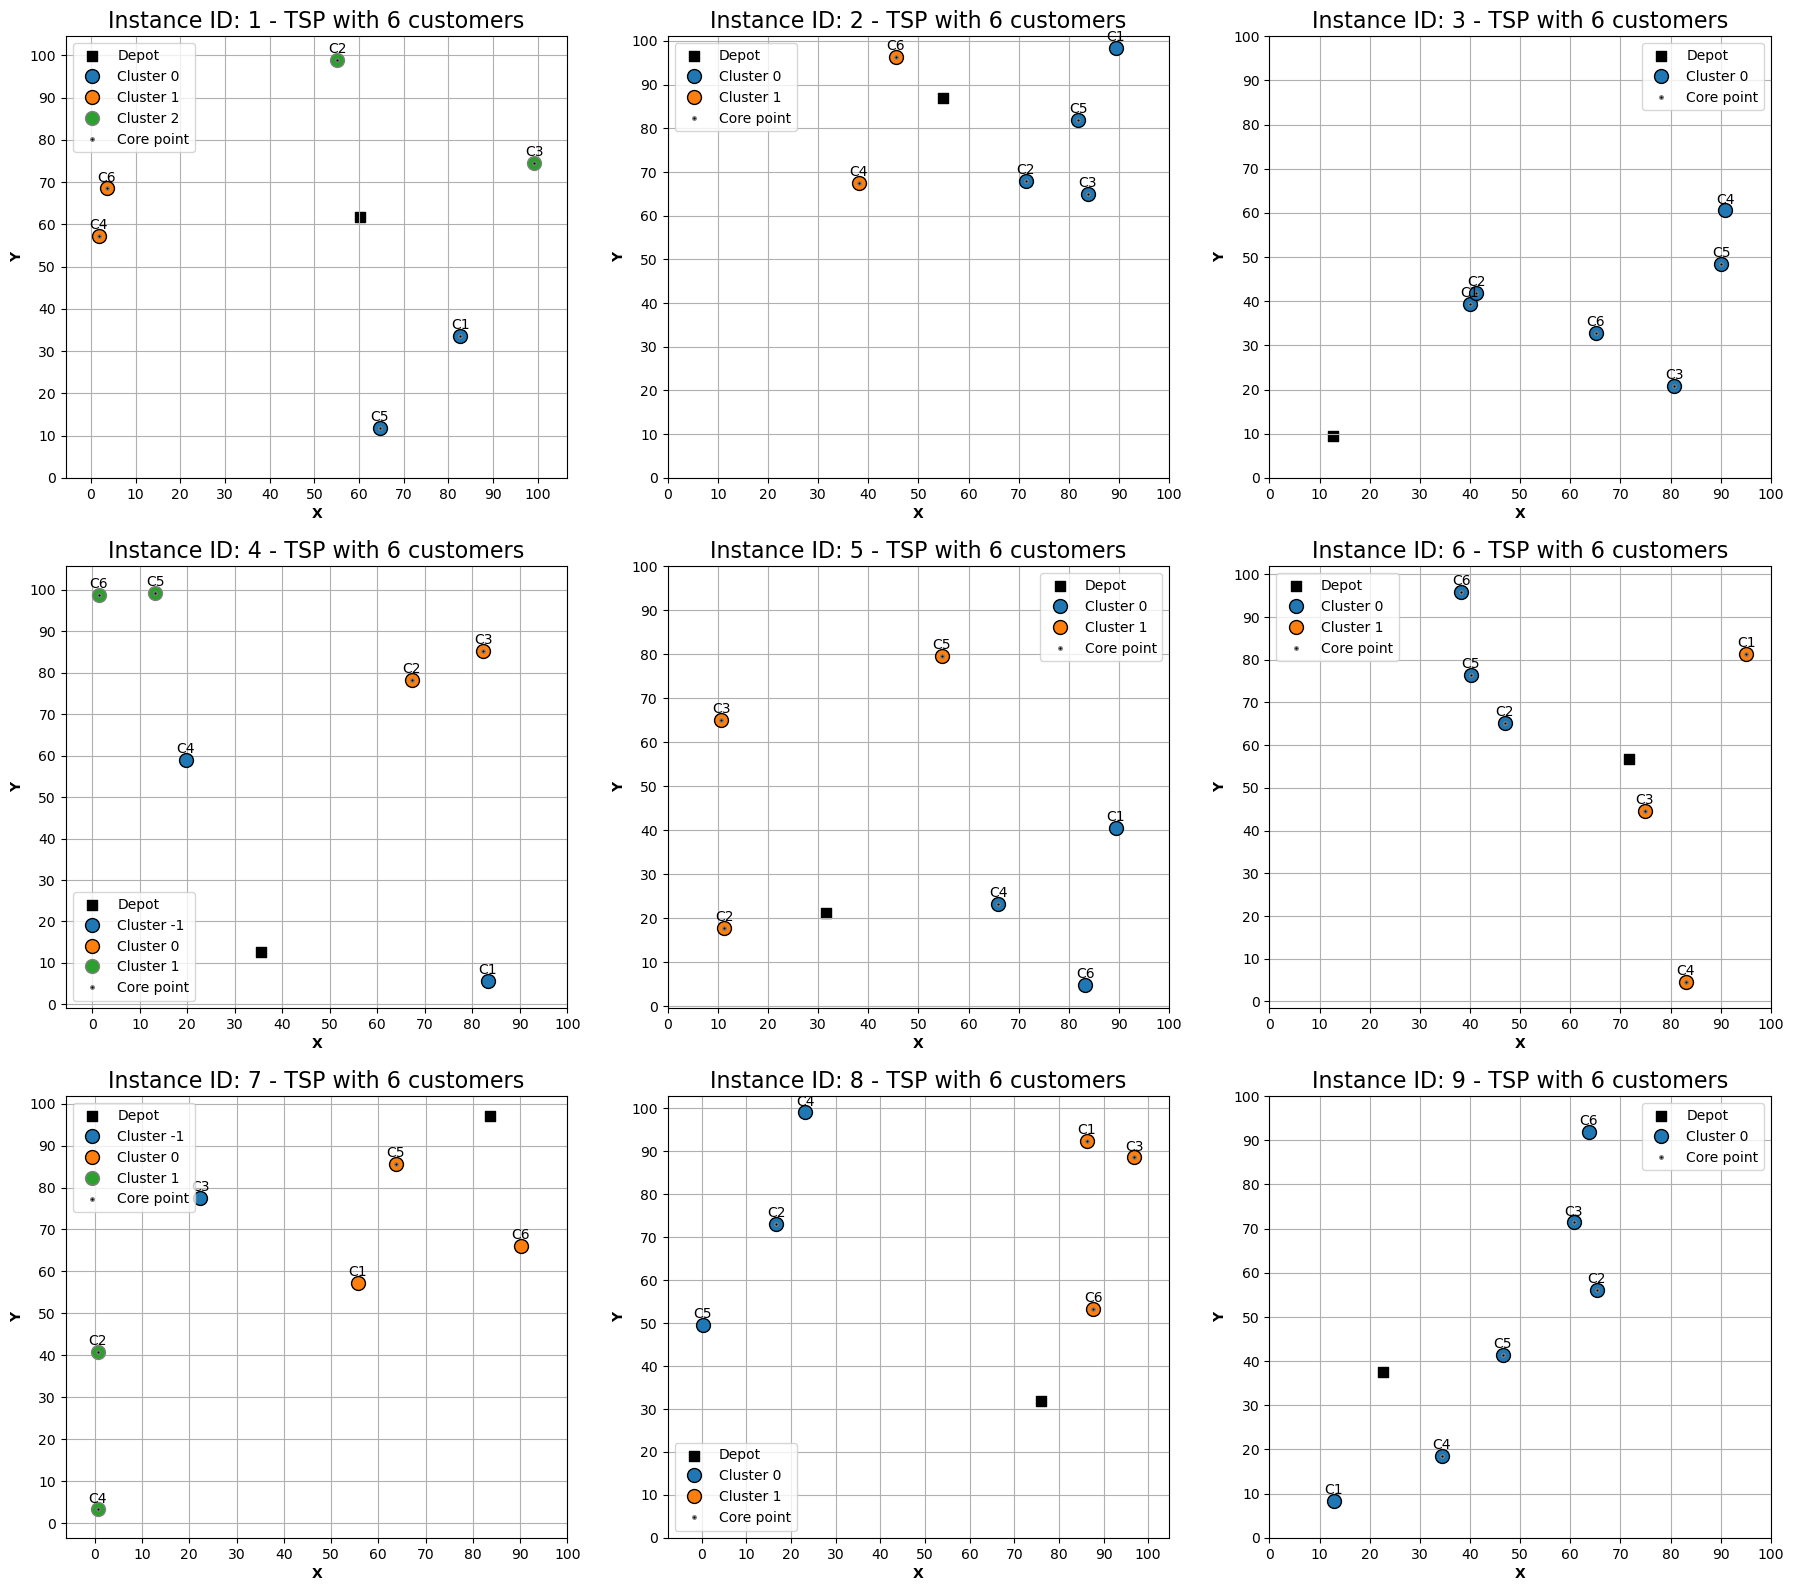

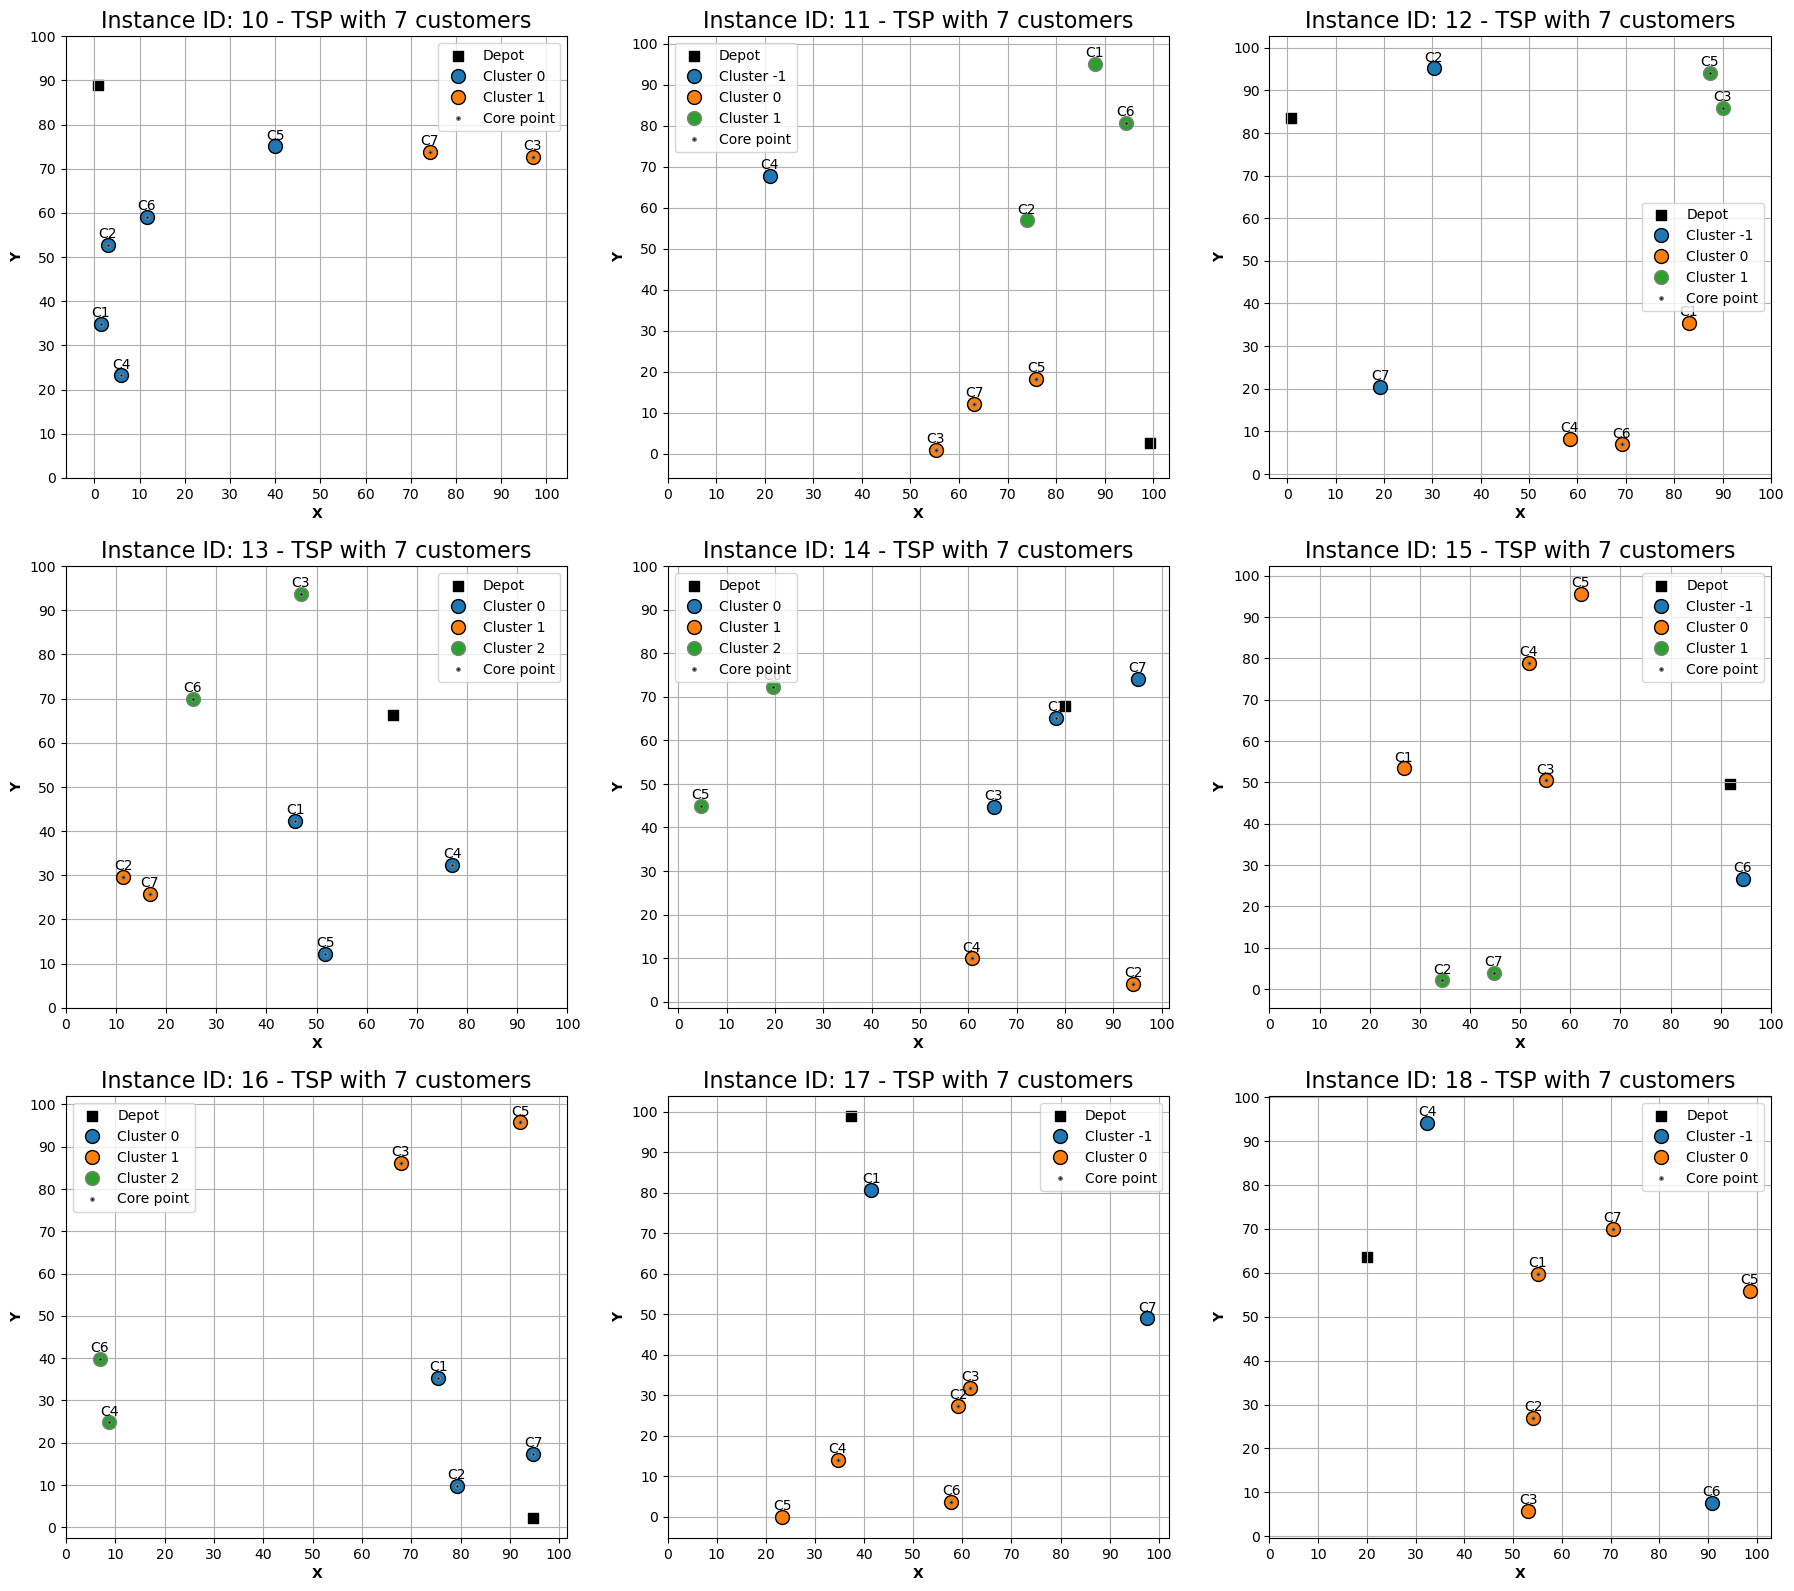

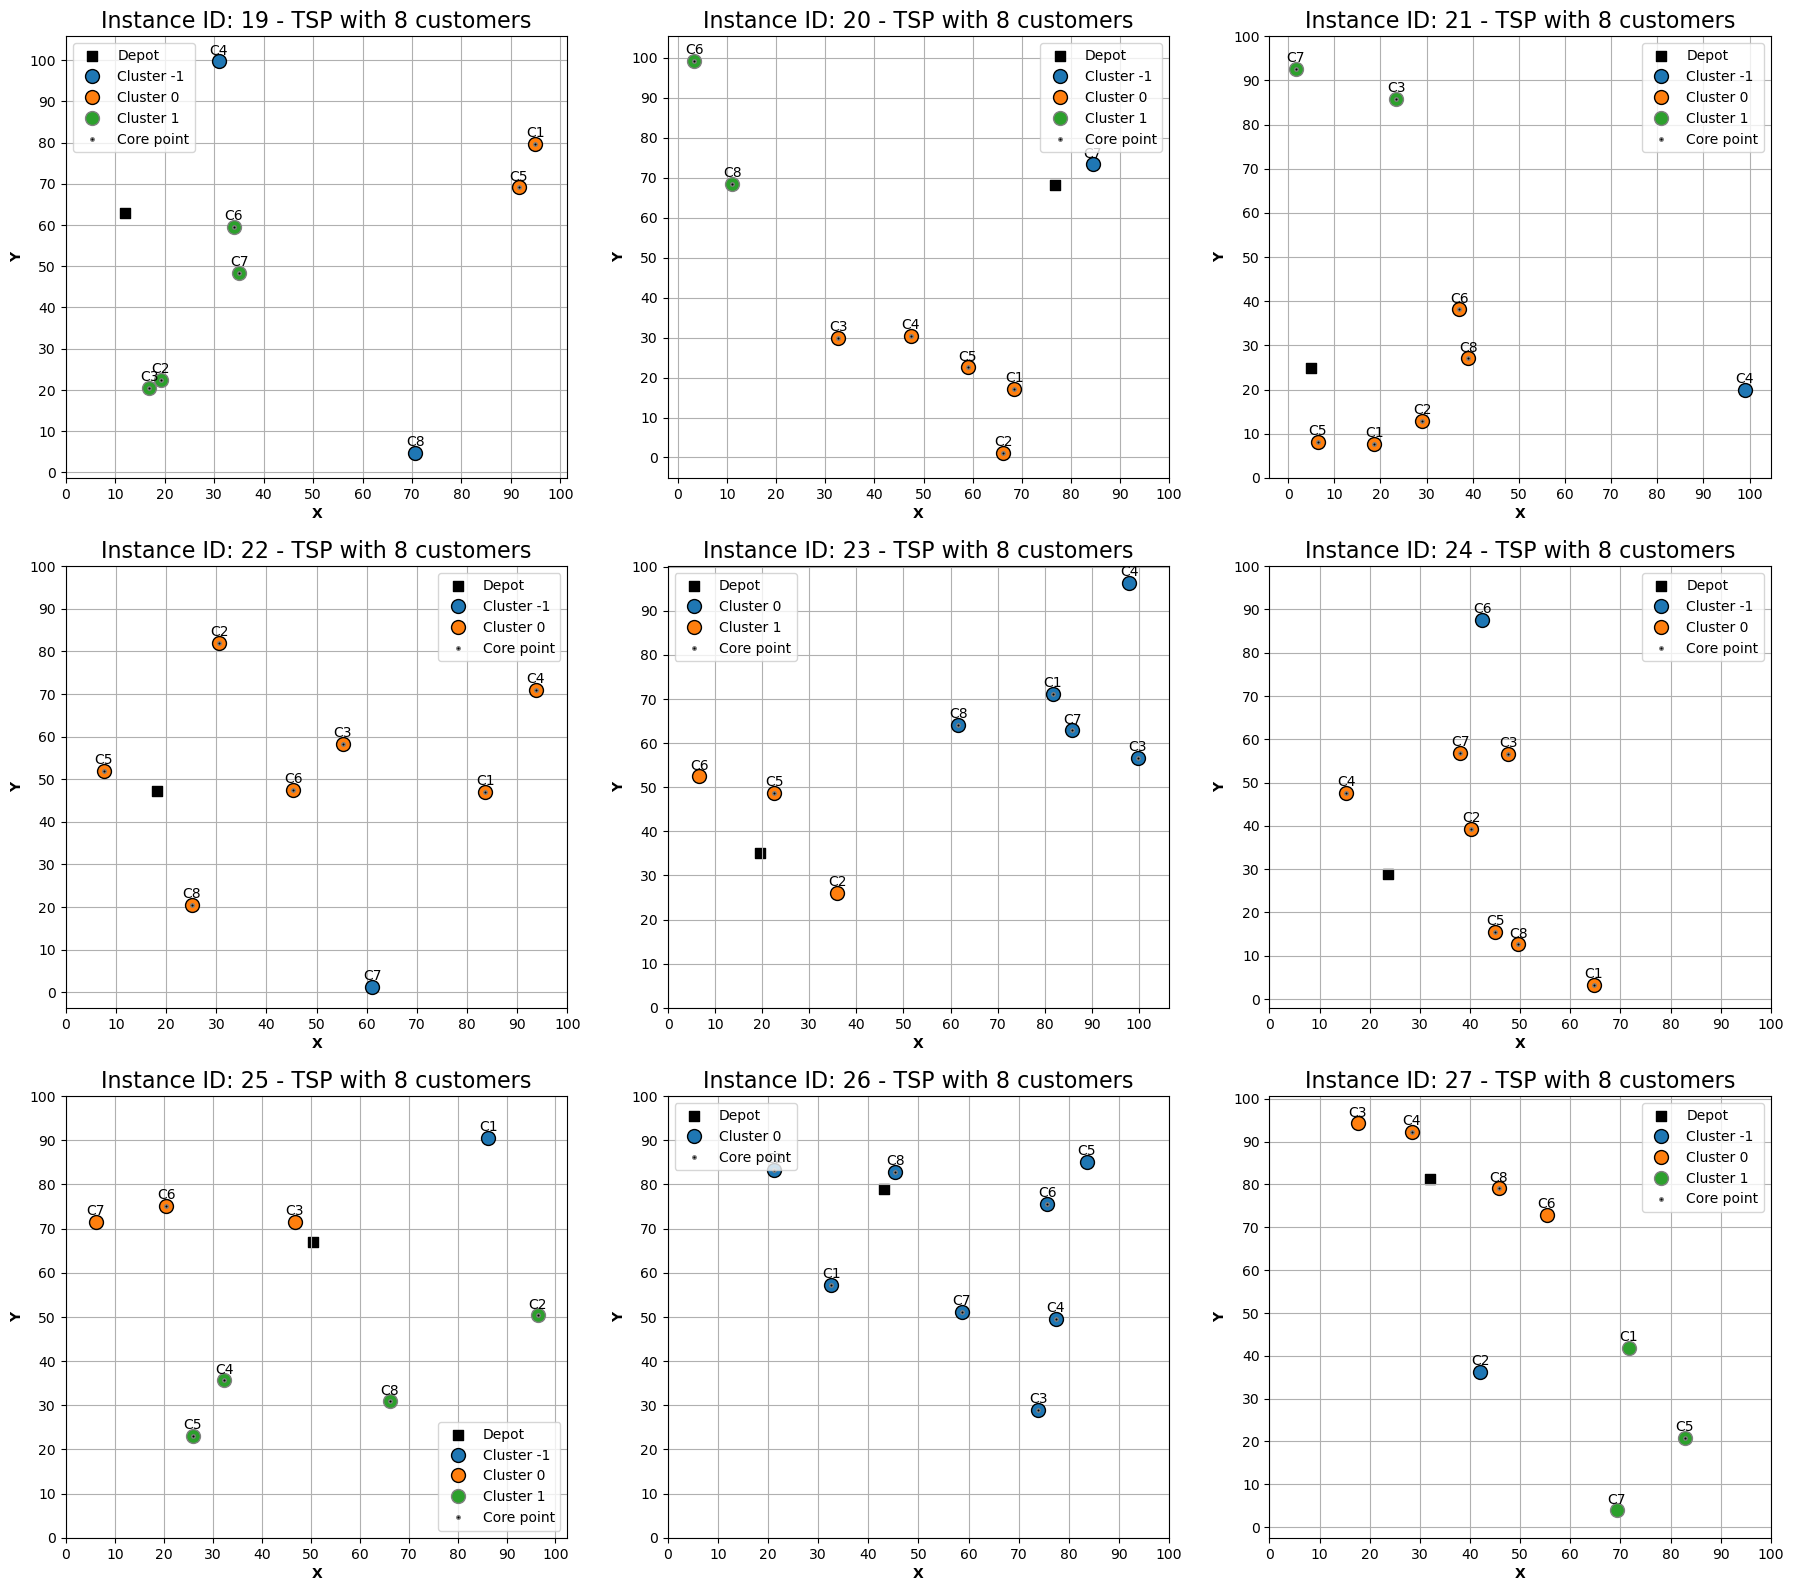

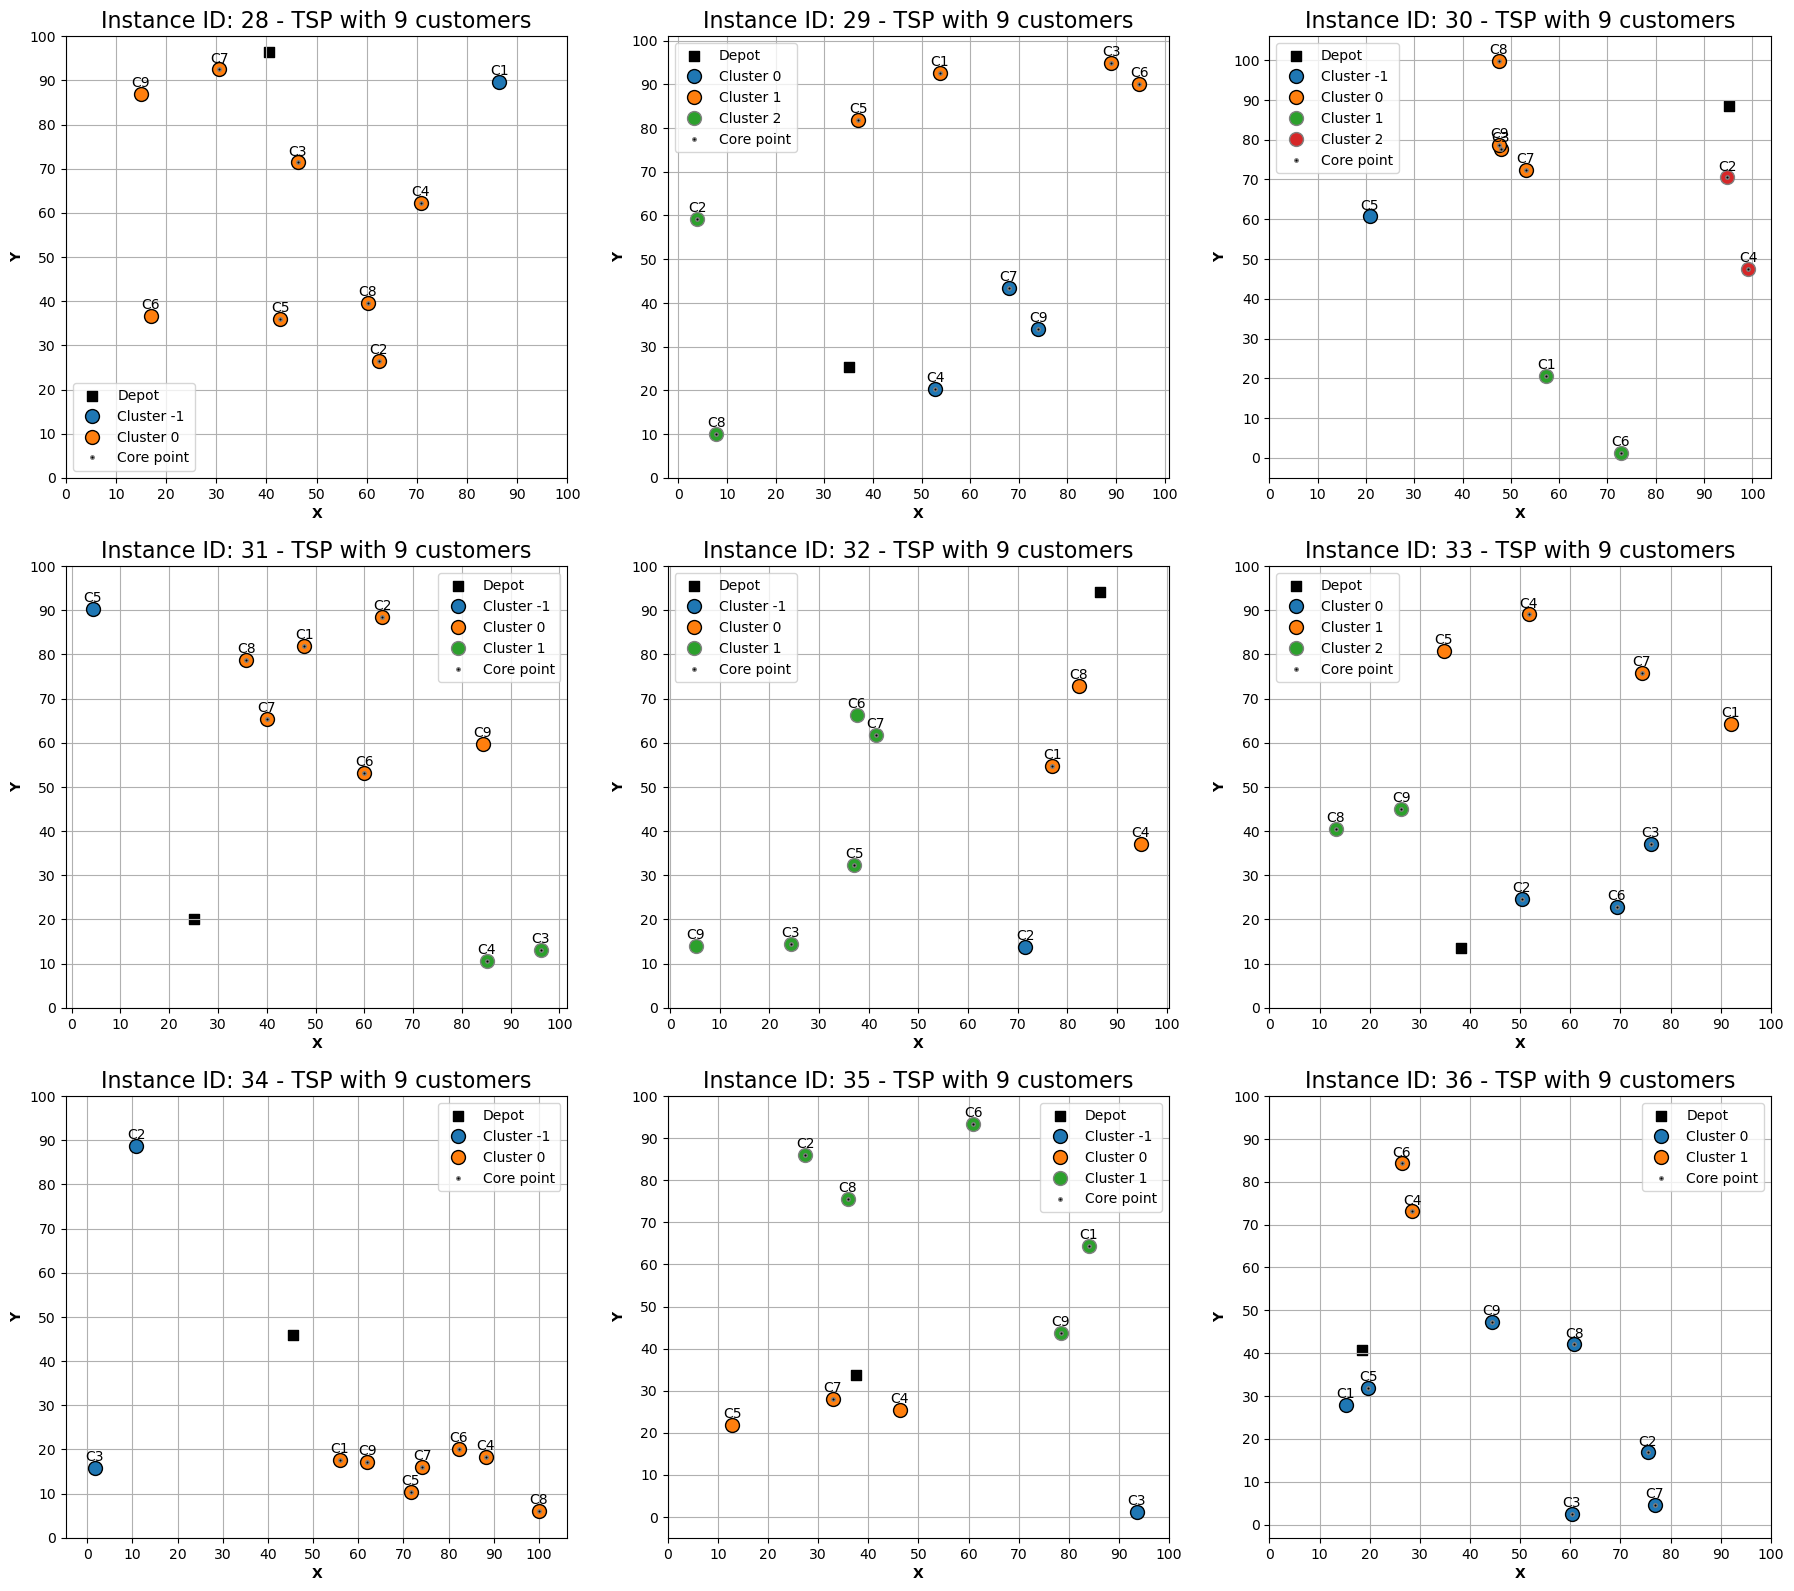

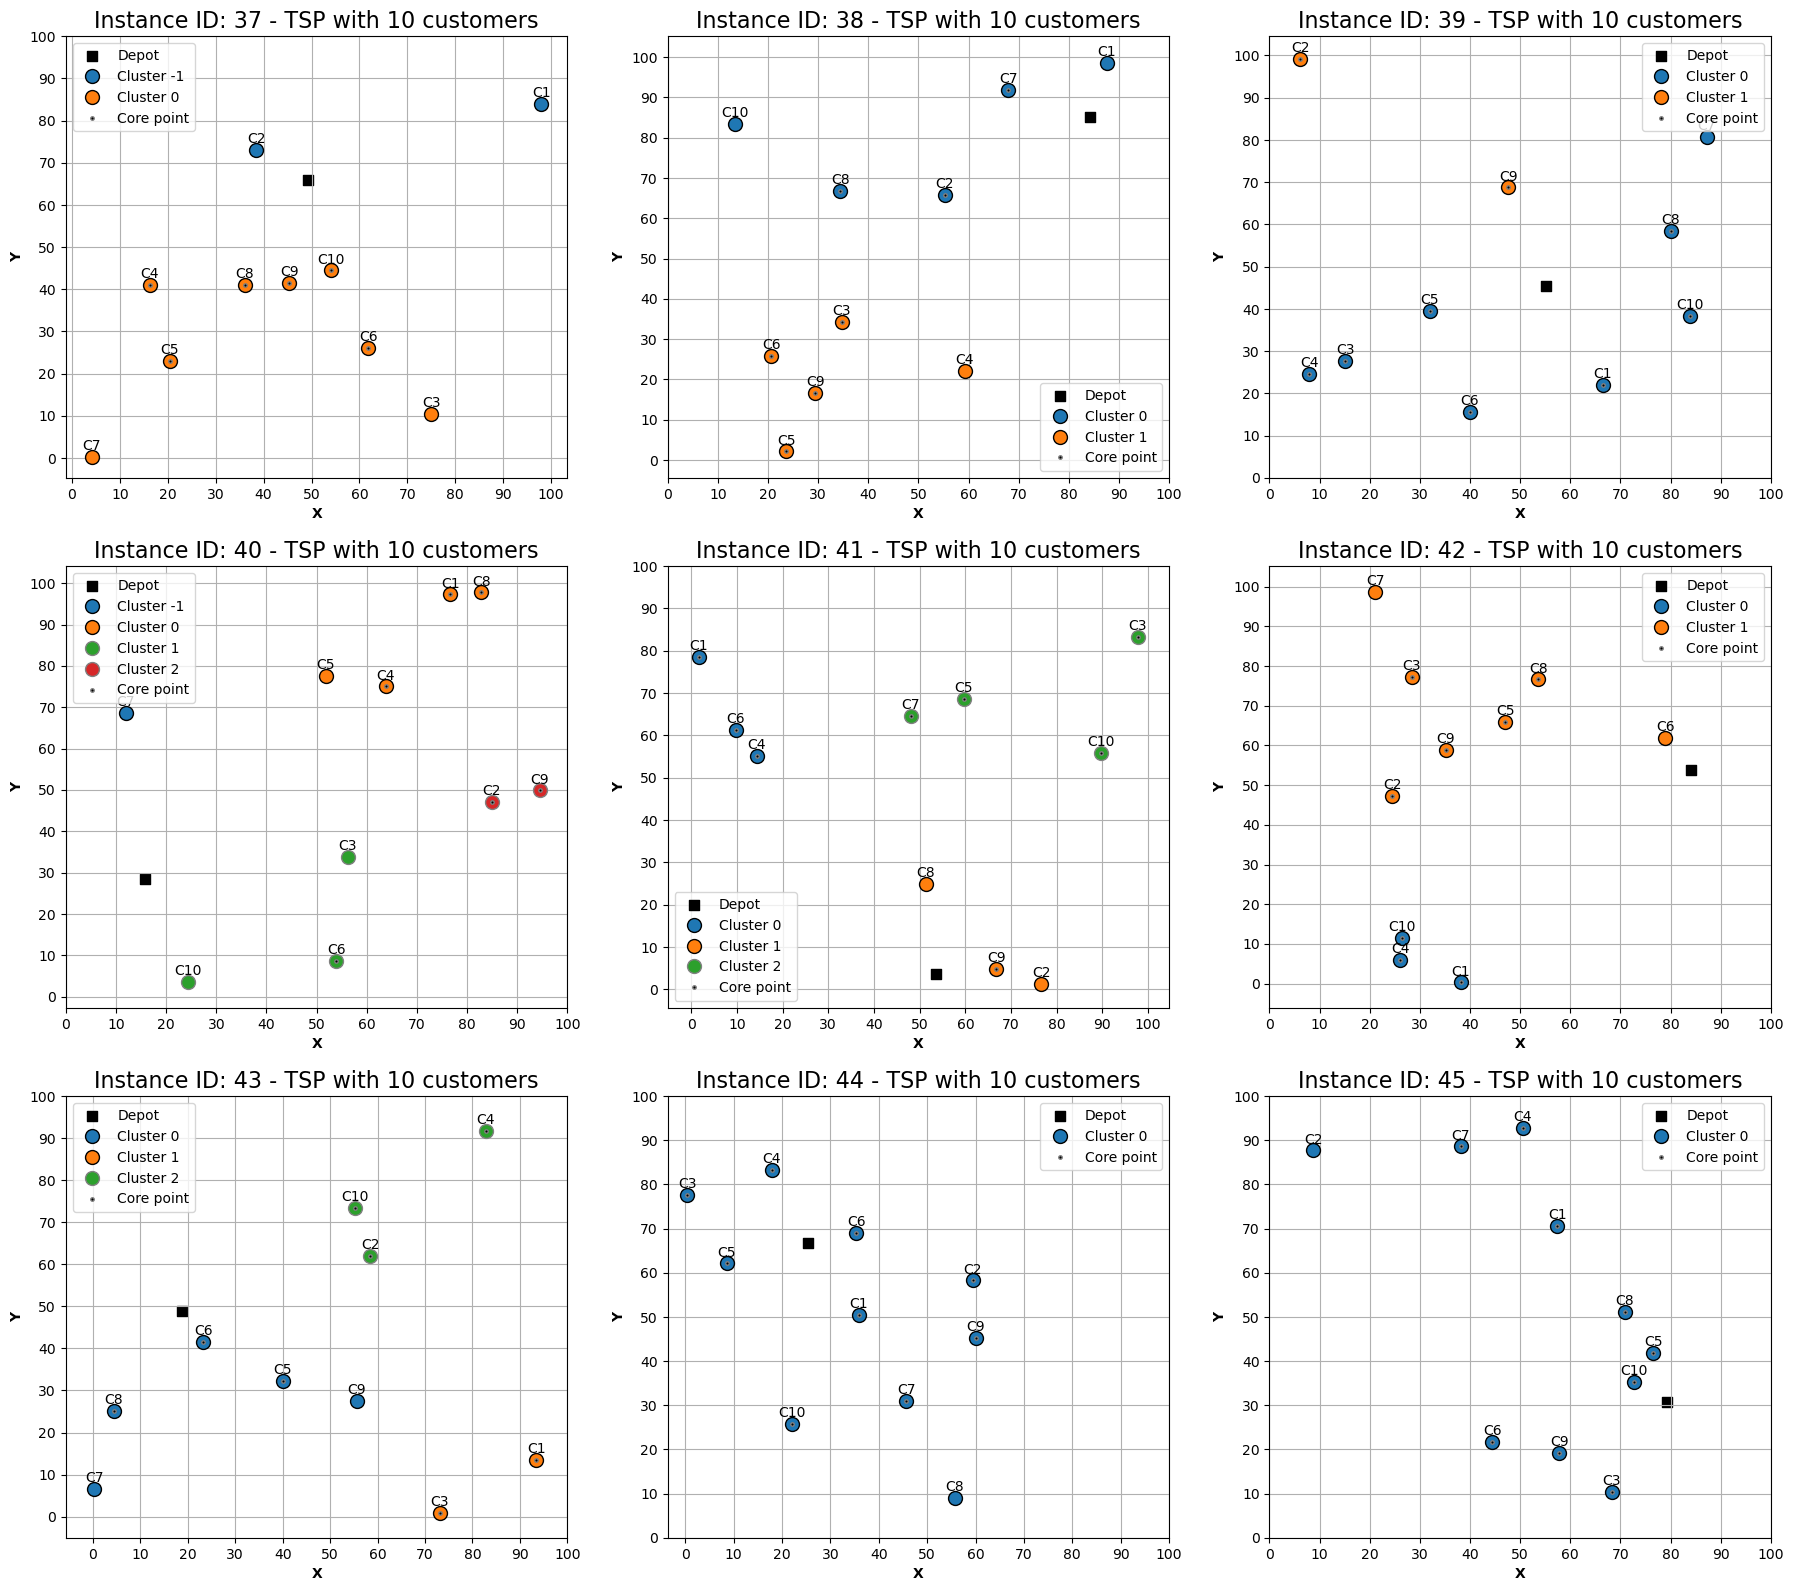

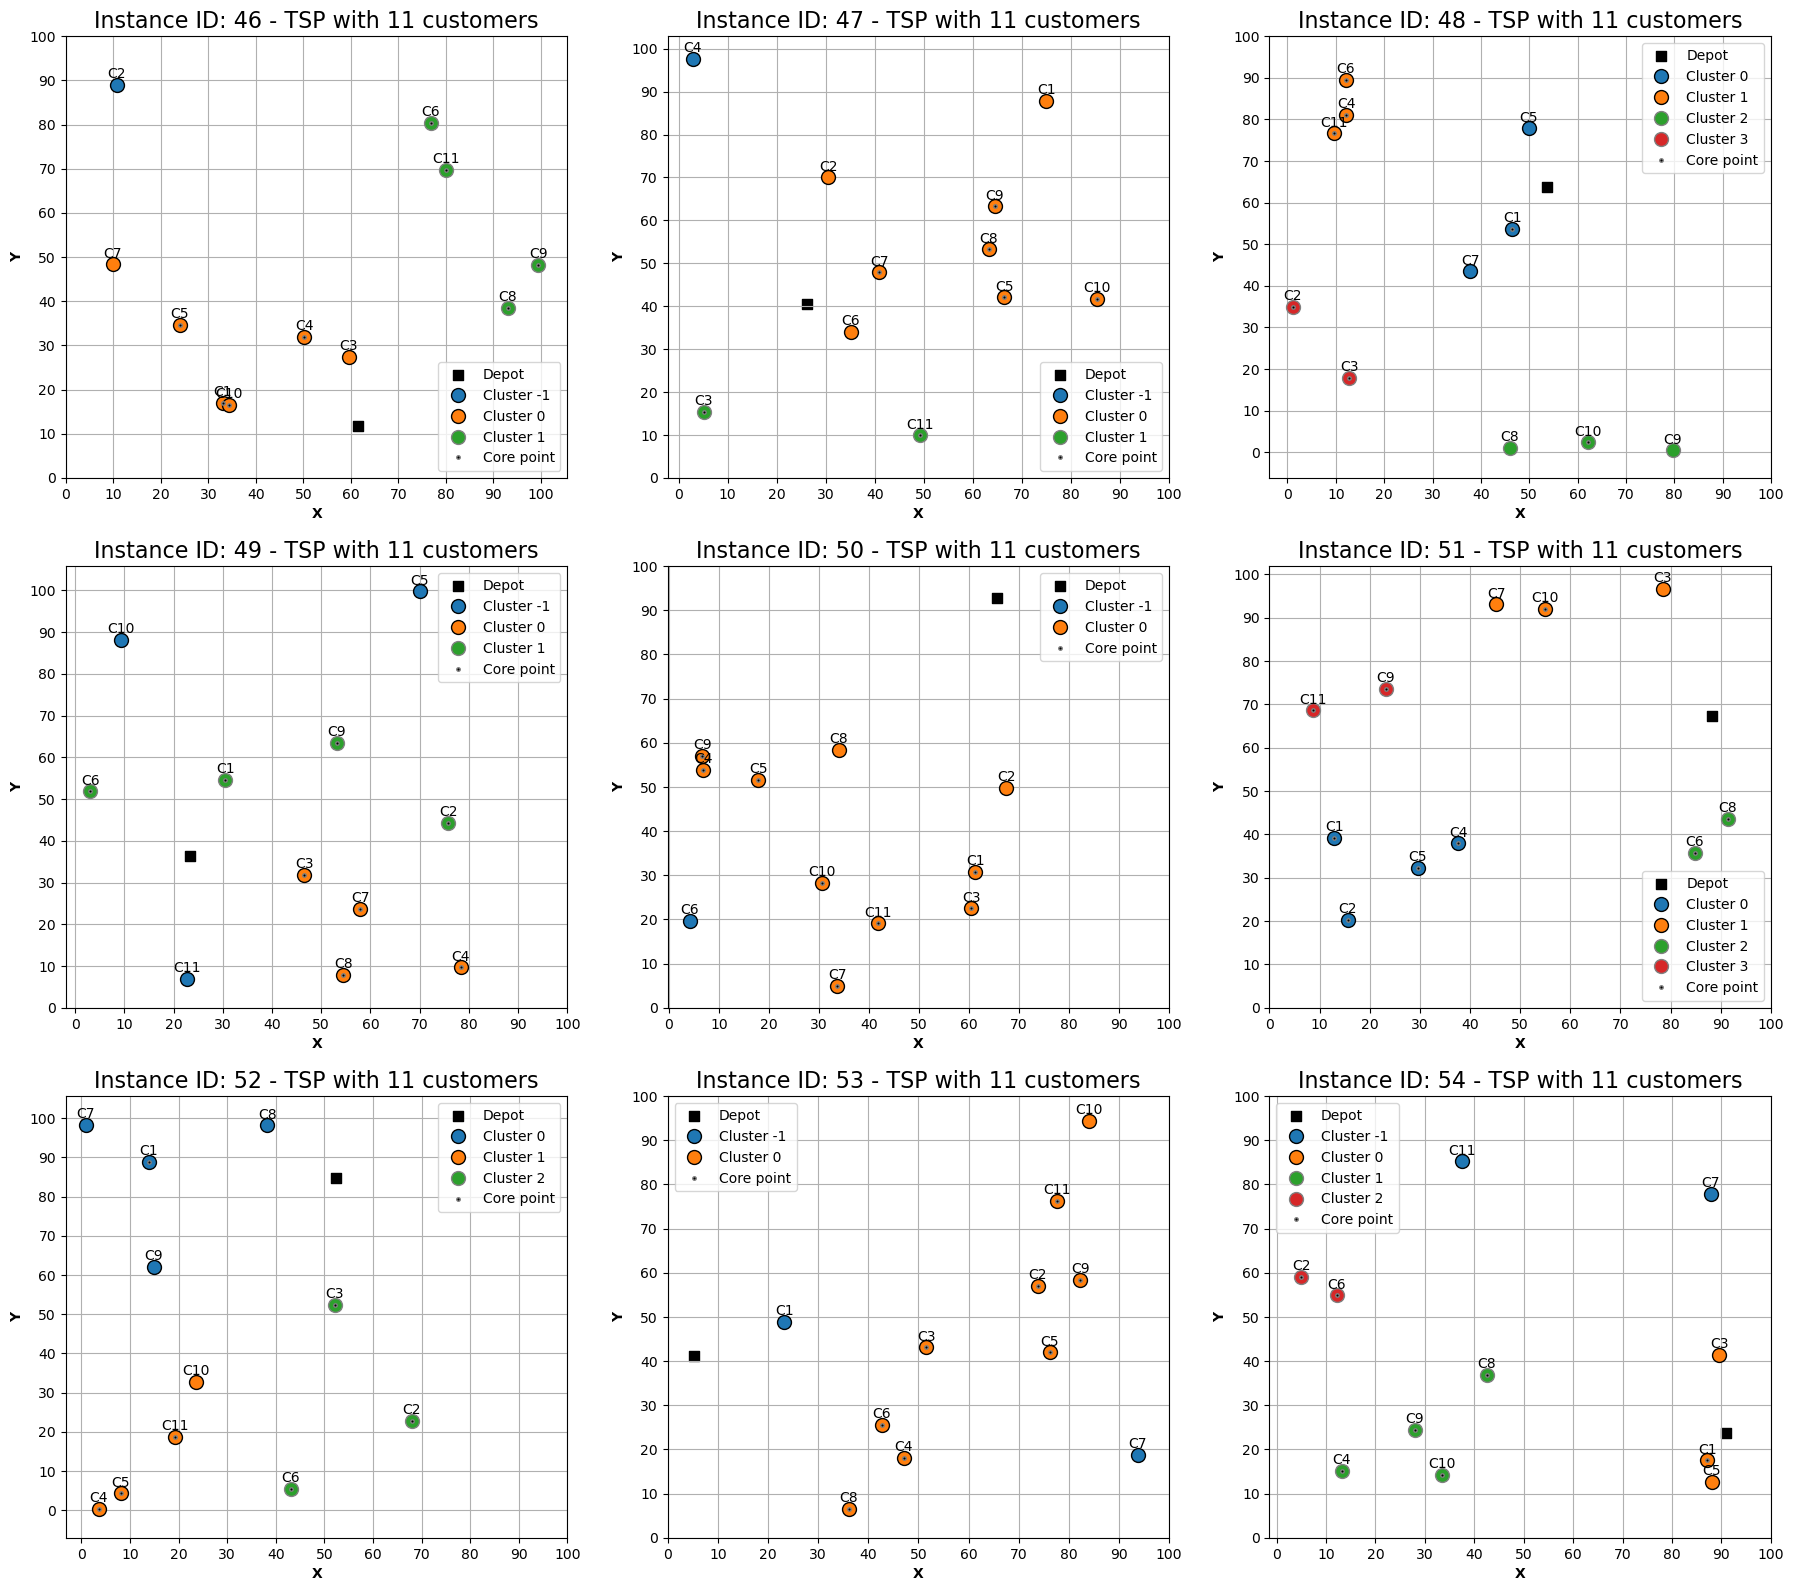

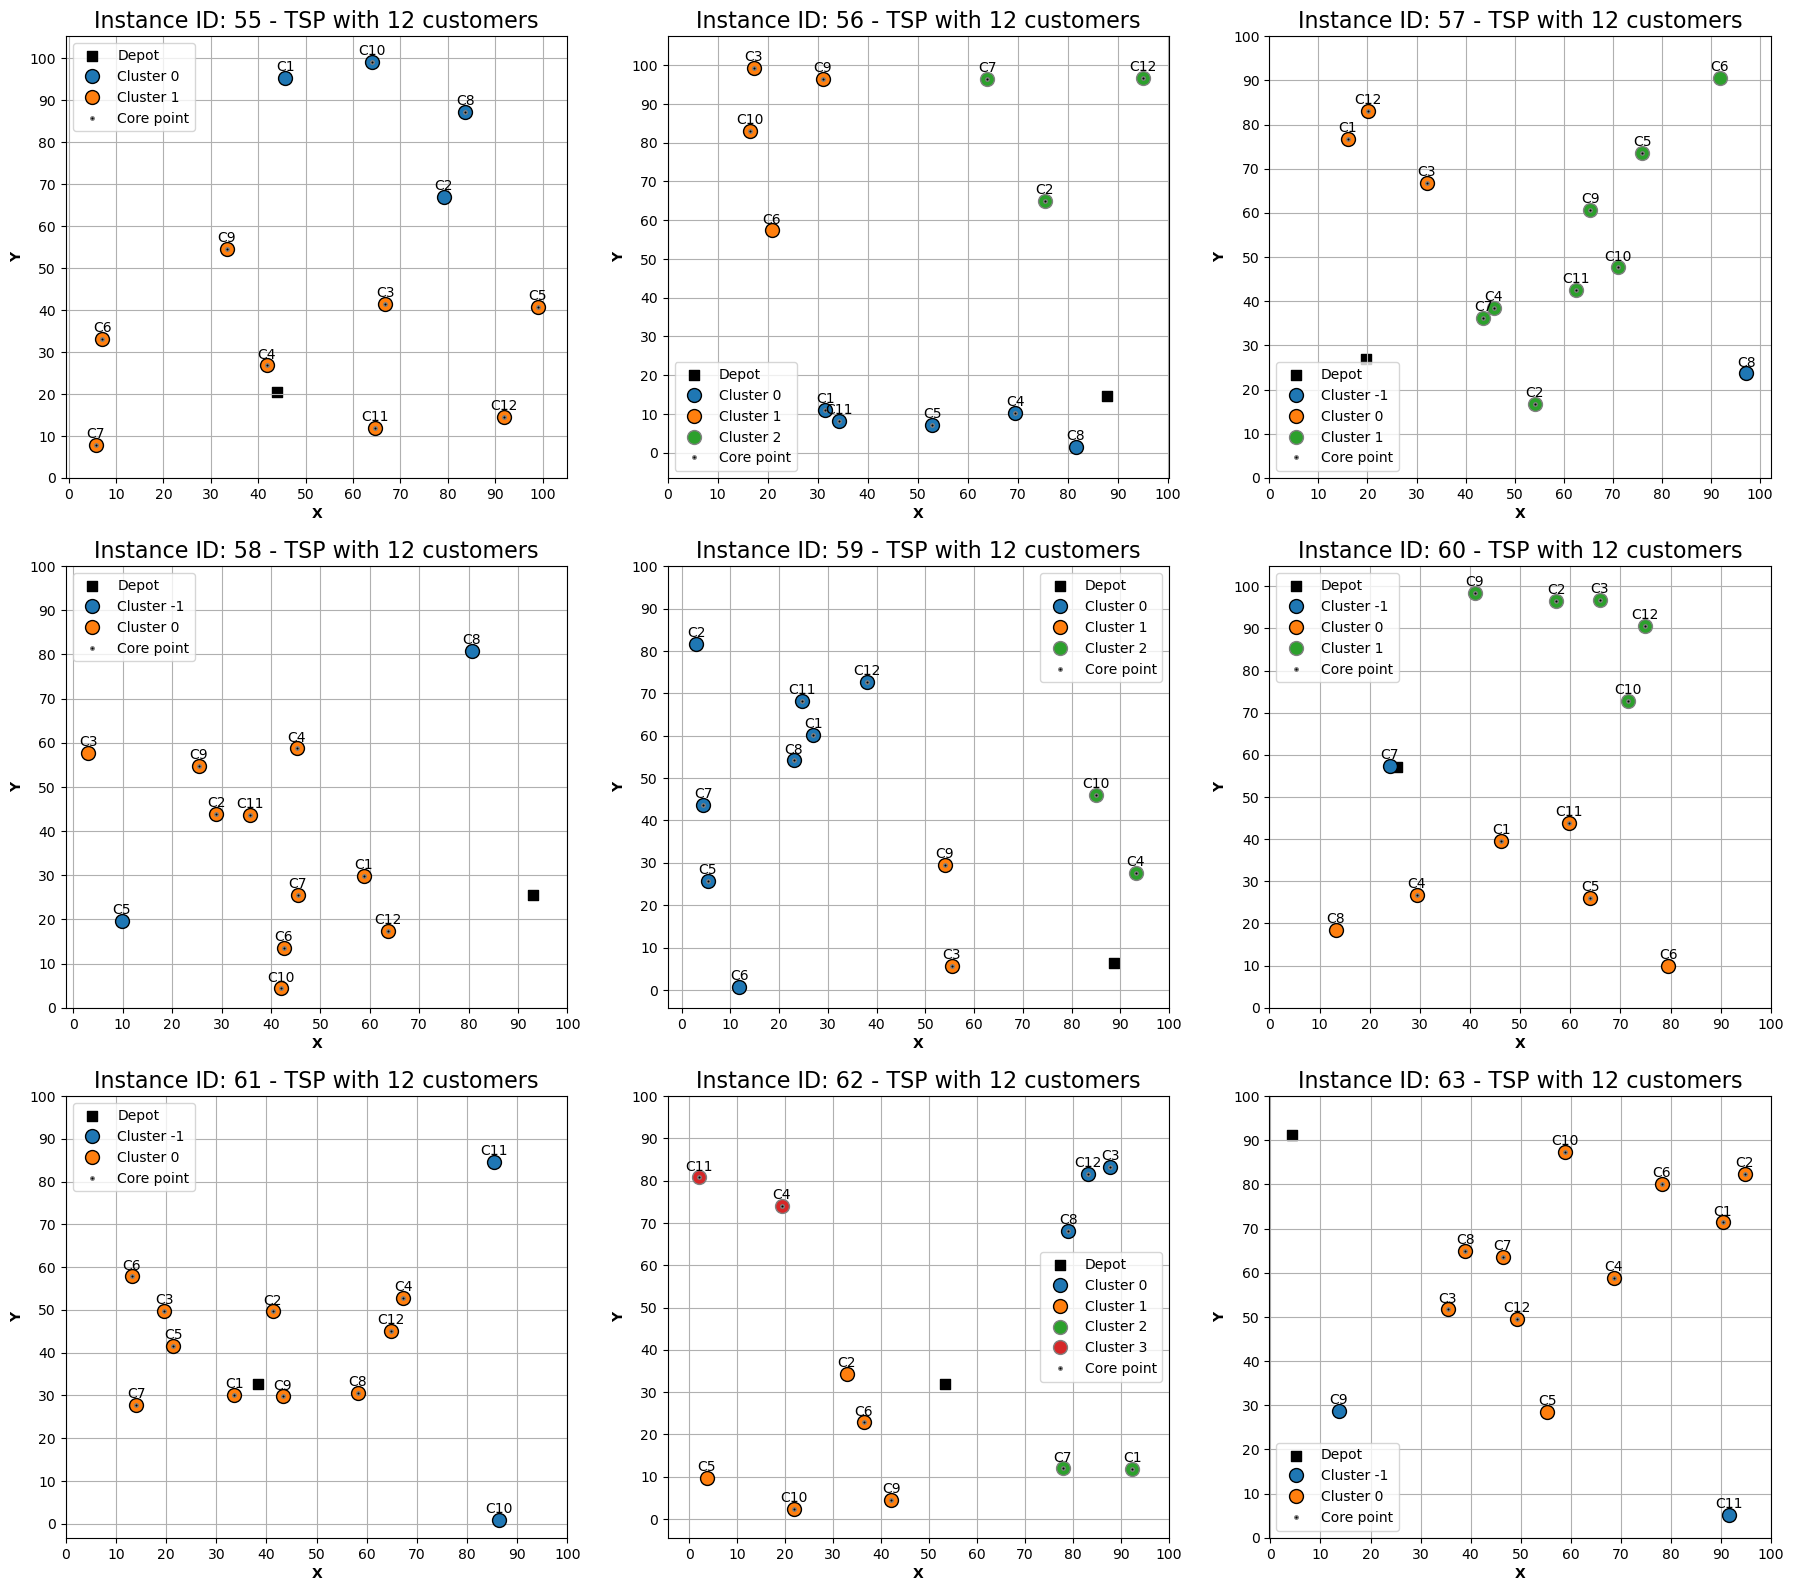

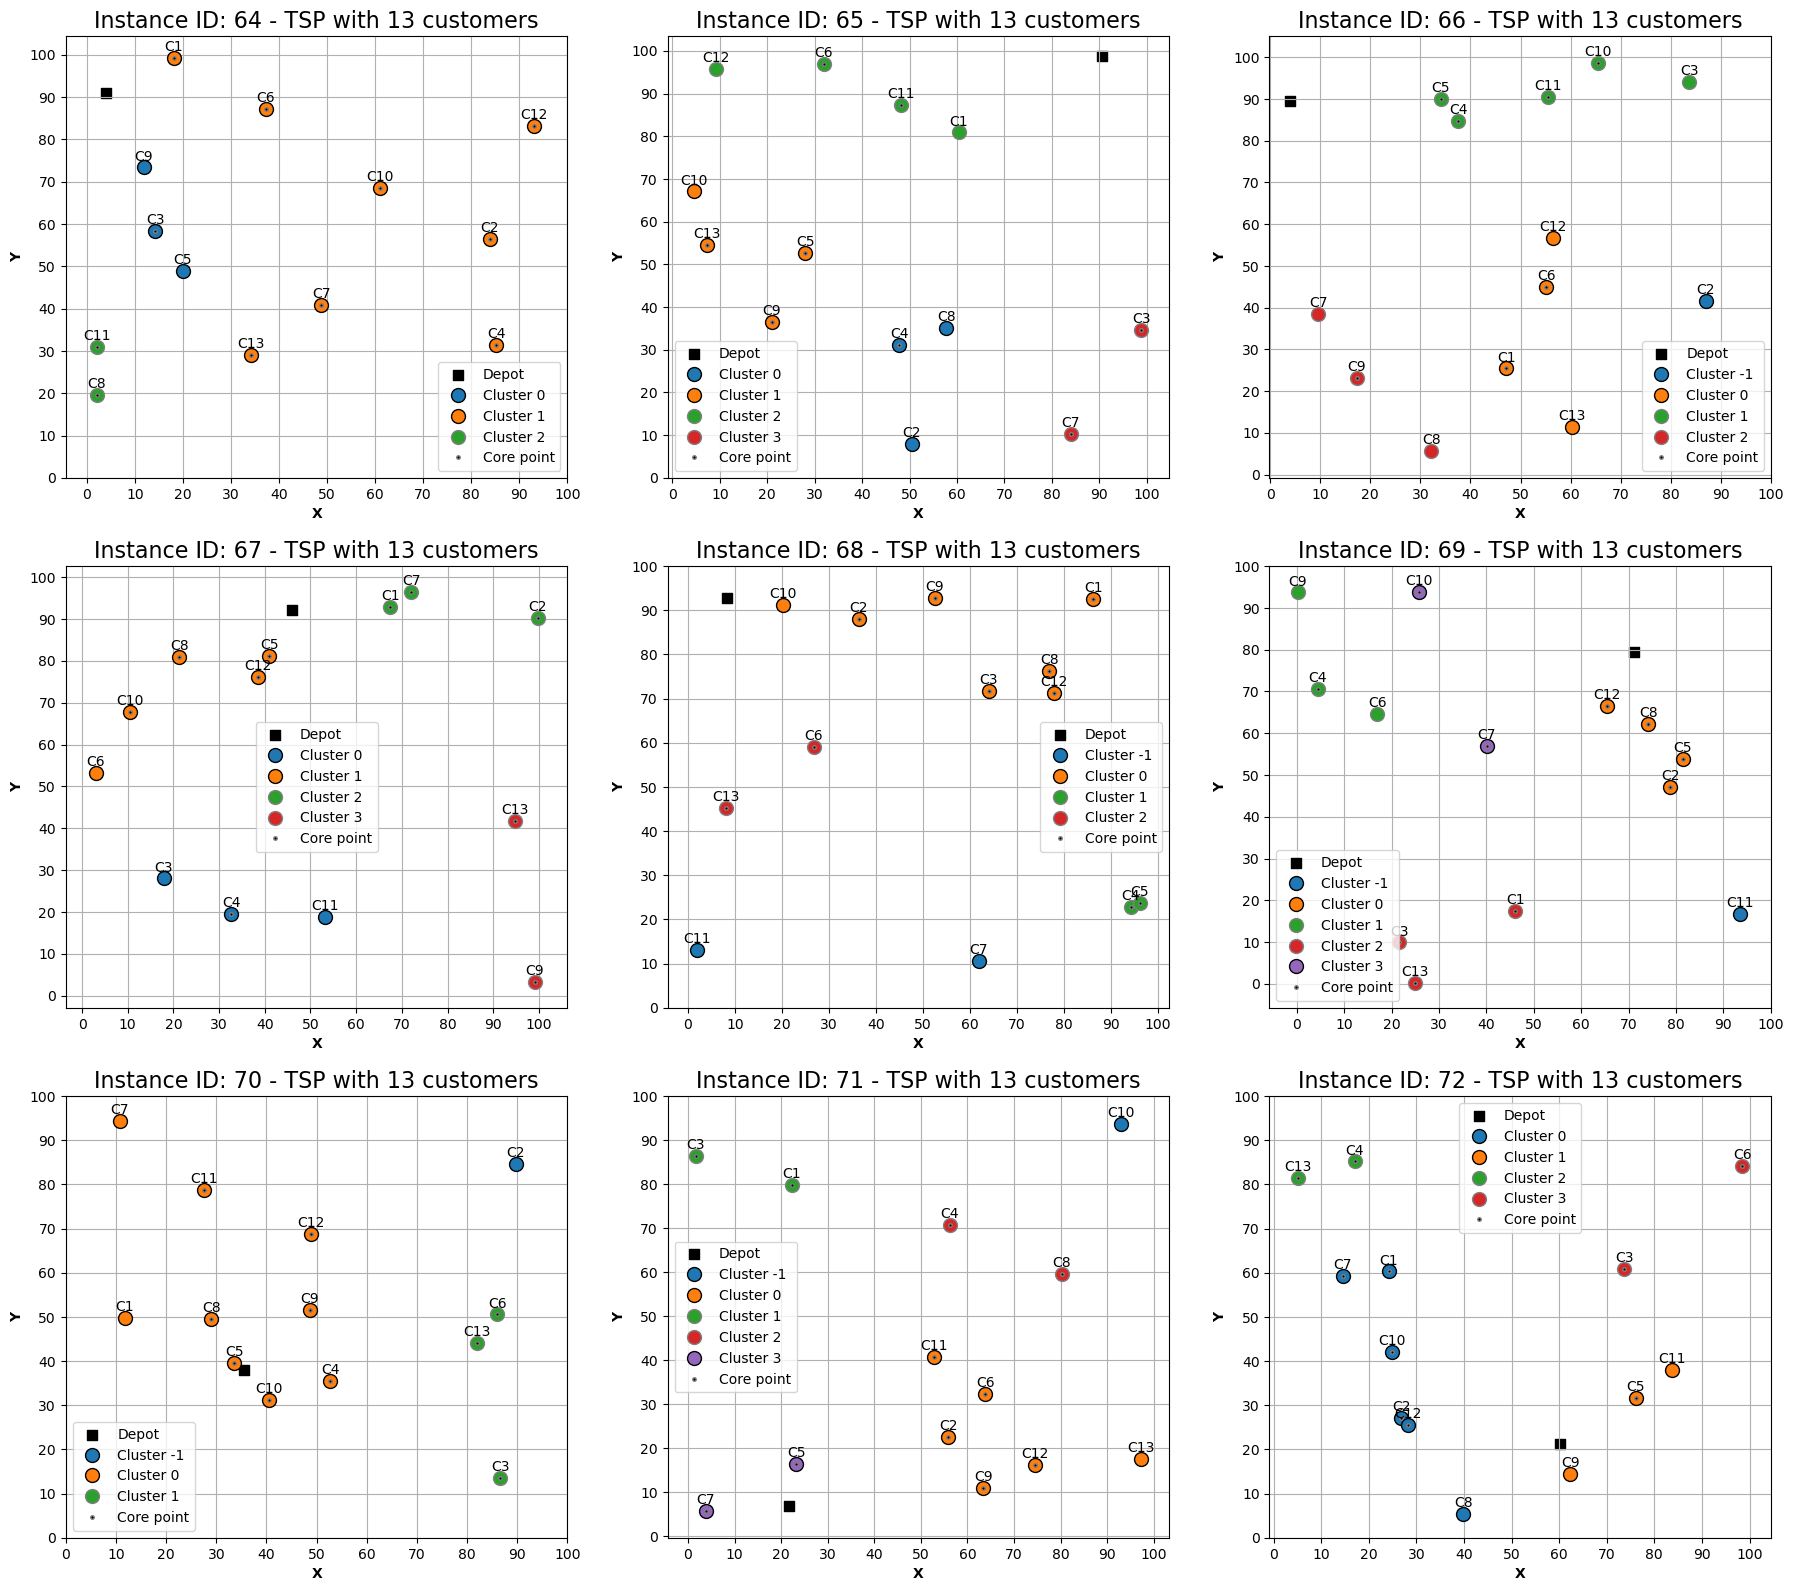

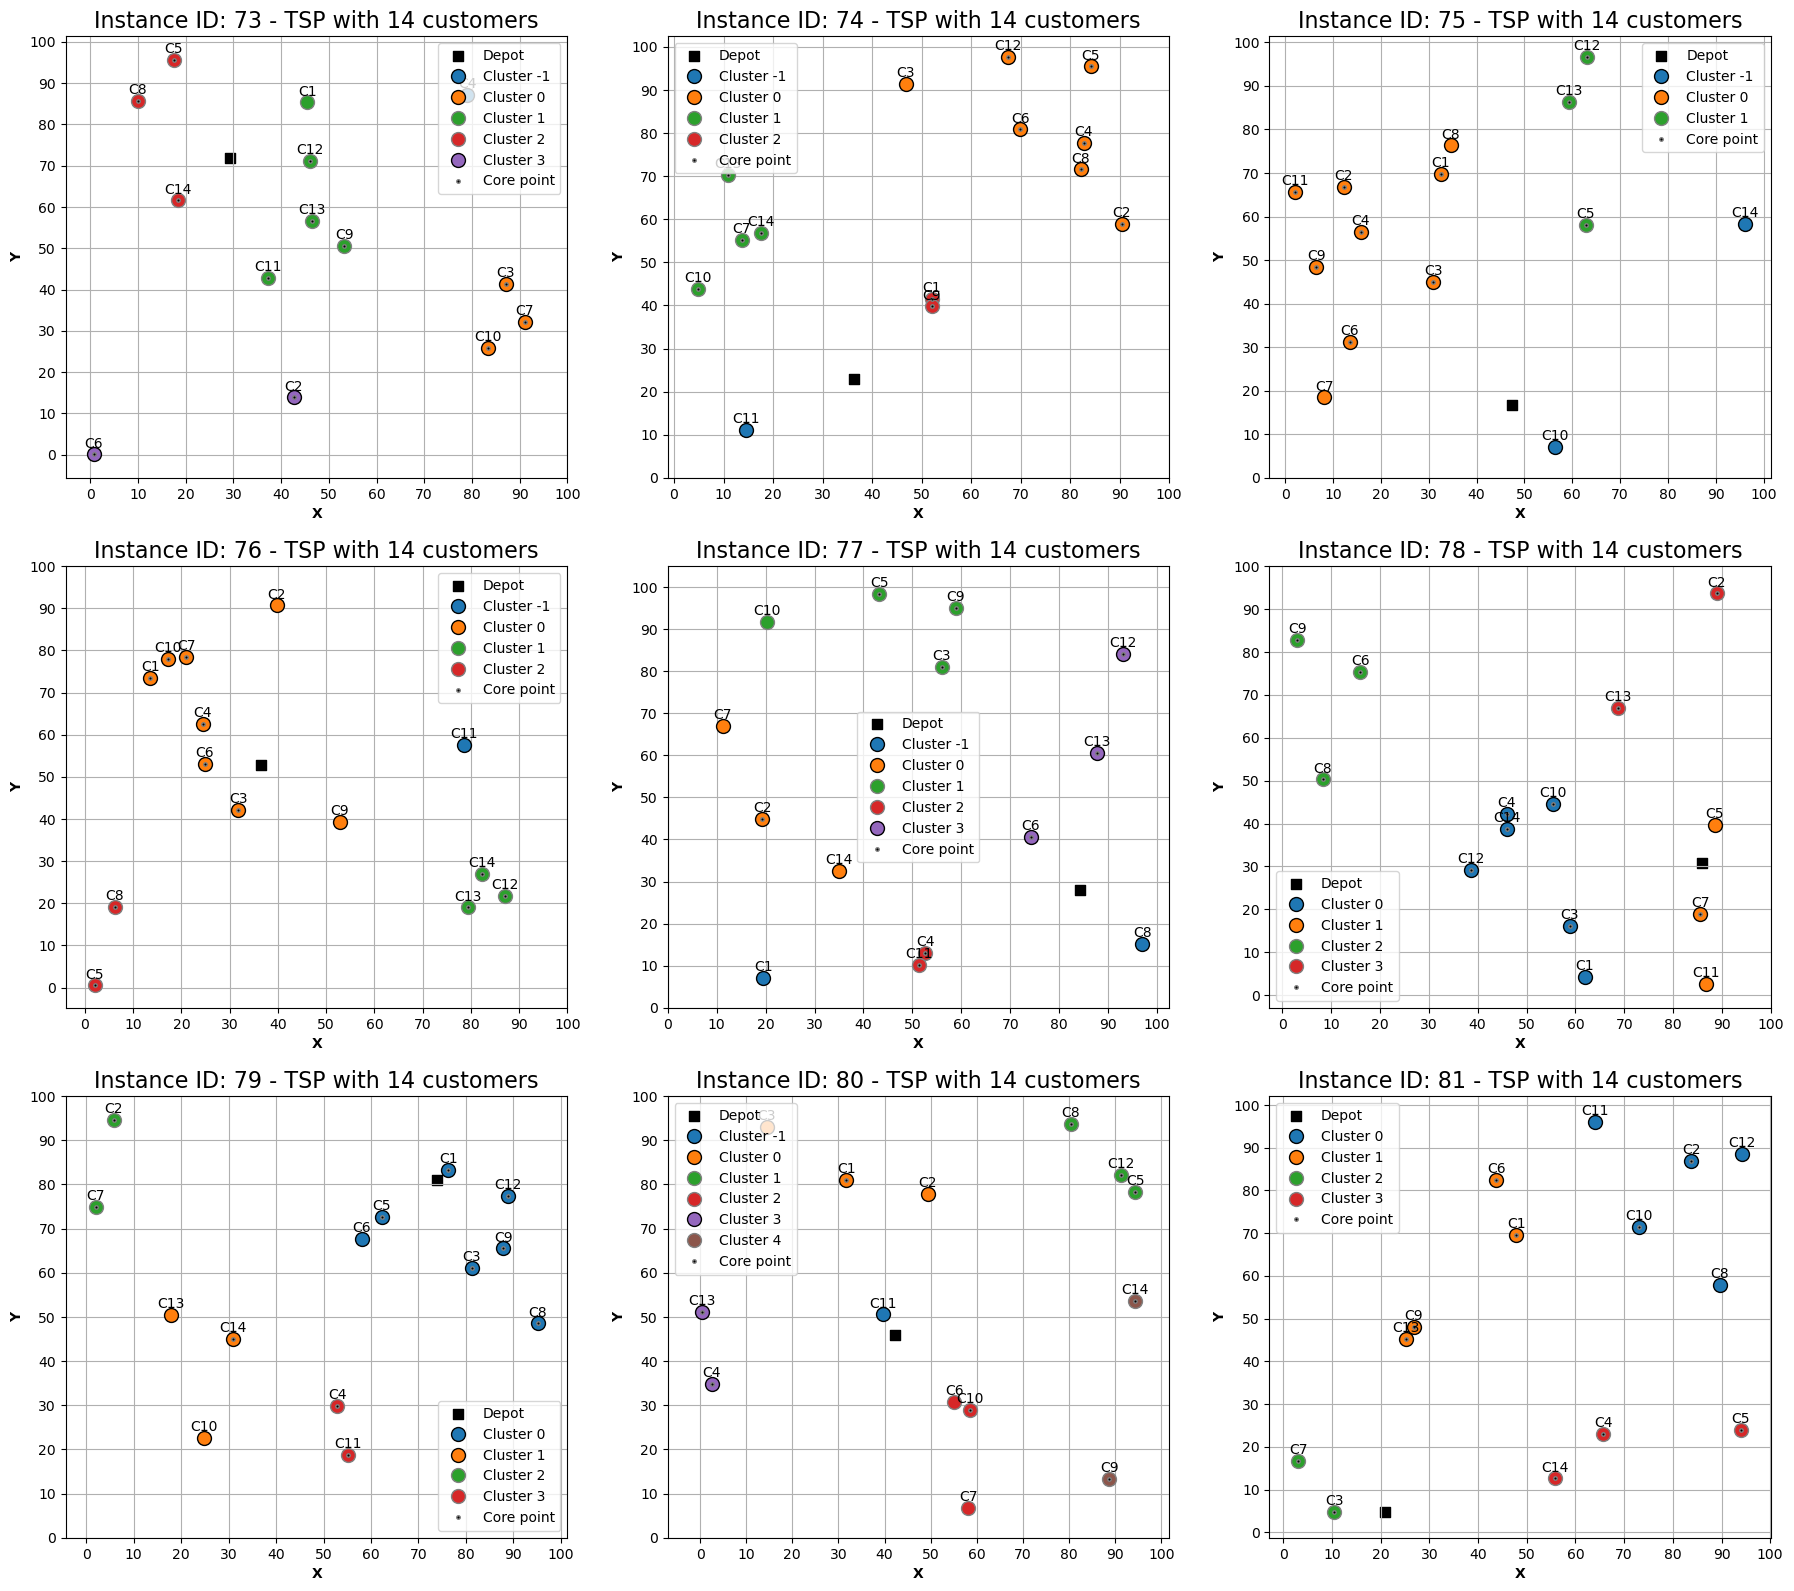

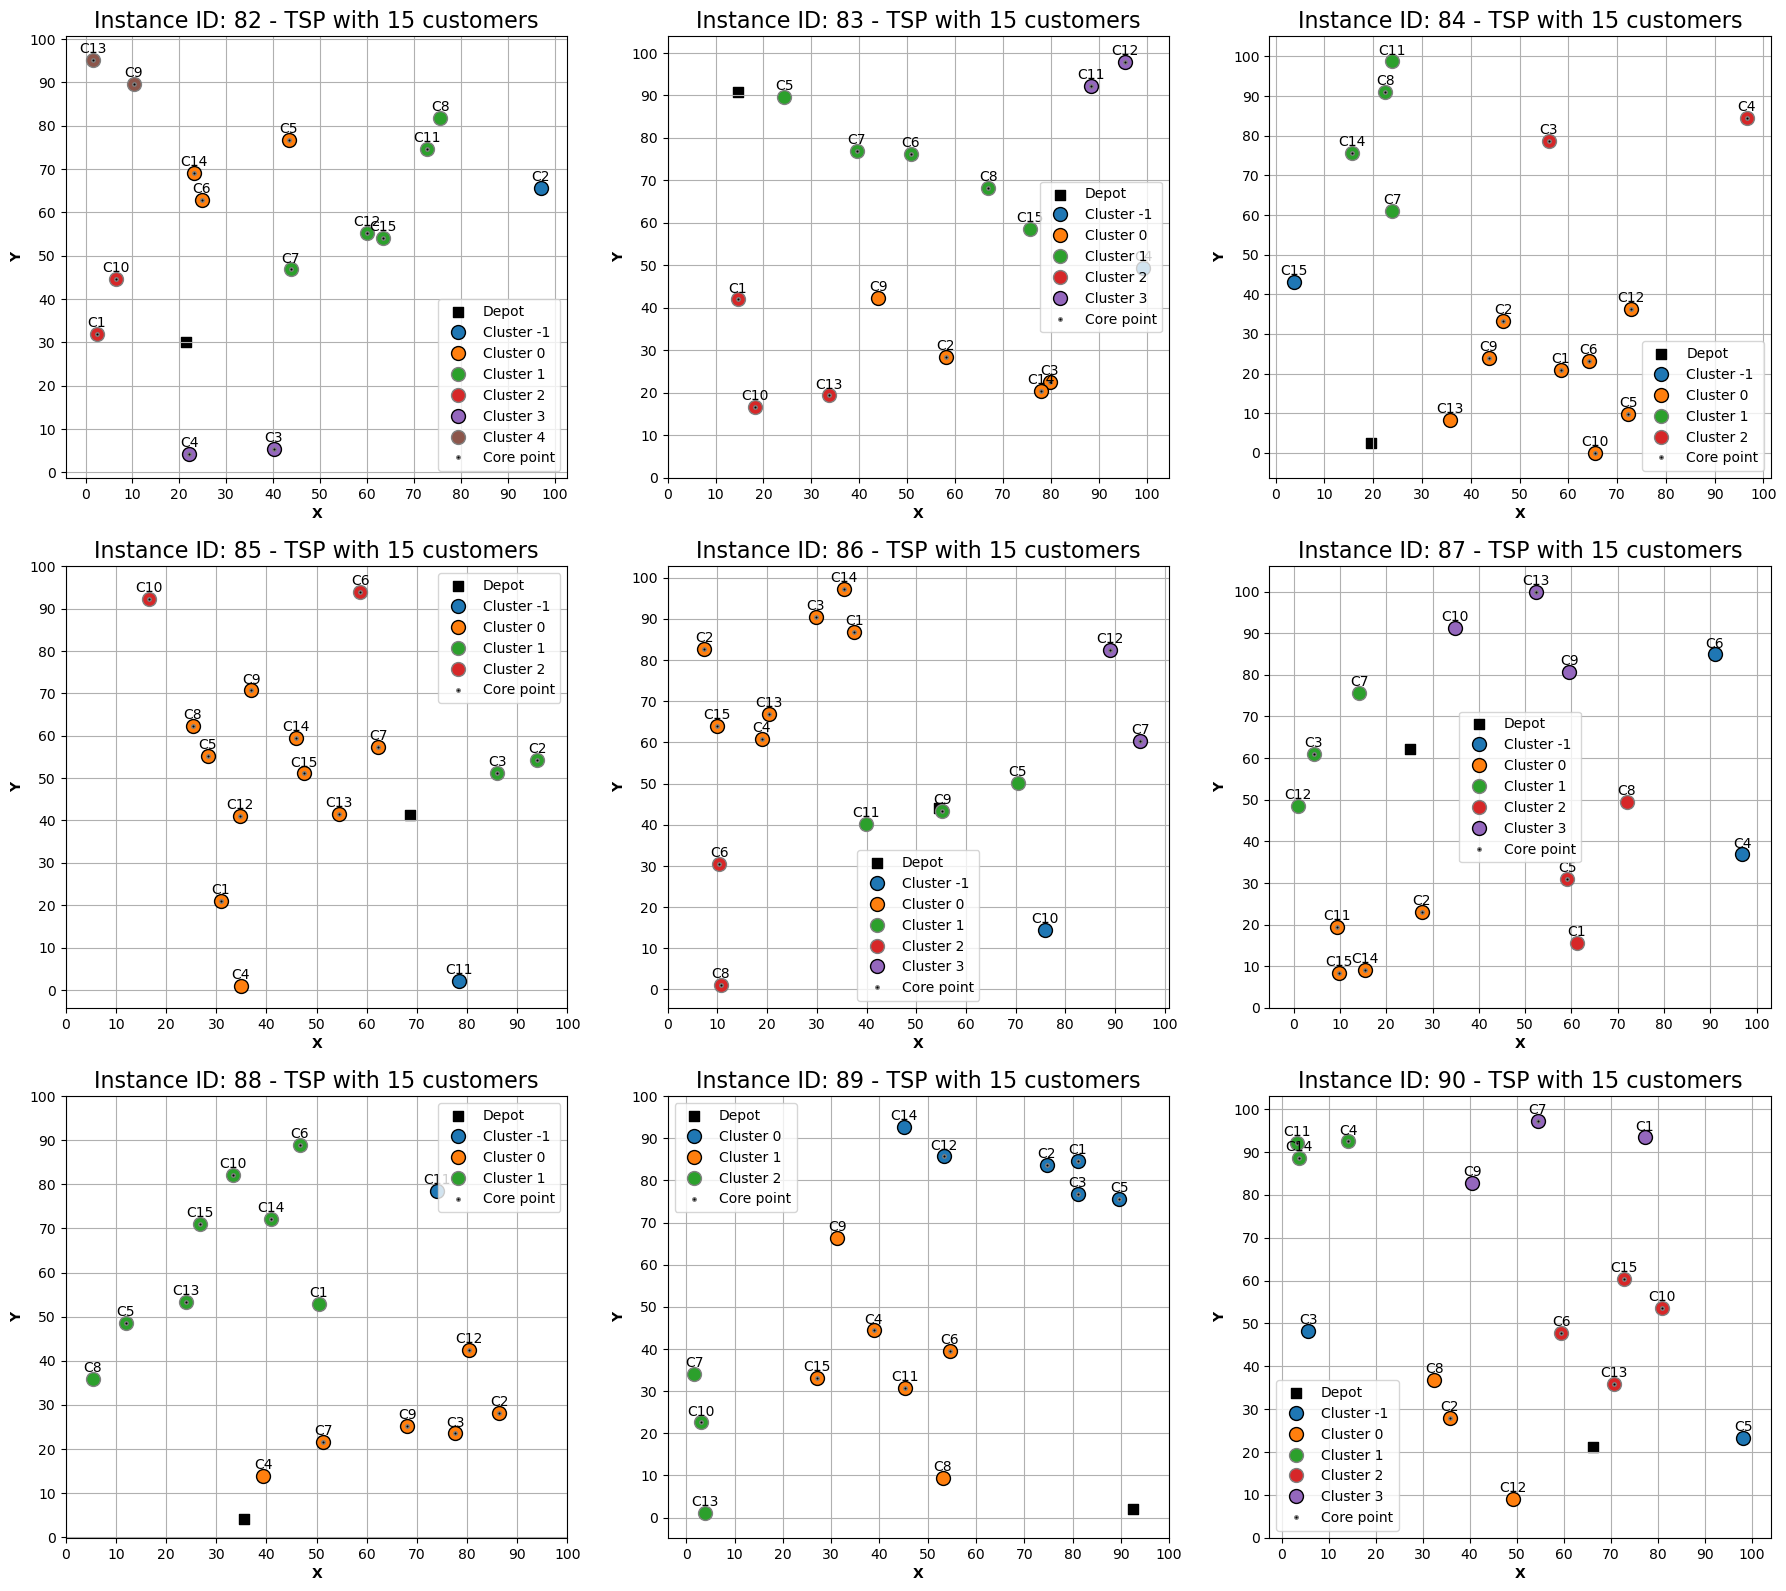

In [9]:
# Define parameters
num_customer_list = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # All possible instance sizes (number of customers for an instance)
number_of_instances_per_size = 9   # Determines the number of instances that are generated for each instance size (number of customers)
columns = 3 # Always plot three TSP instances in one row
rows = math.ceil(number_of_instances_per_size / columns) # Compute the number of rows for a given number_of_instances_per_size
instances = [] # List to store all generated TSP instances - for possible later investigation purposes
instance_id = 1

# Iterate over the list with possible instance sizes
for num_customers in num_customer_list:

    # Create subplots and modify the plot size dynamically
    fig, axs = plt.subplots(rows, columns, figsize=(22, rows*6.5))

    # Generate three TSP instances for all rows and plot them in the corresponding position of the subplot
    for row in range(rows):
        for column in range(columns):
            # Generate a new TSP instance
            tsp_instance = generate_random_tsp_instance(num_customers=num_customers, x_range=x_range, y_range=x_range)
            coord = [(tsp_instance['X'][i], tsp_instance['Y'][i]) for i in range(len(tsp_instance))]
            sequence, total_costs  = solve_tsp(coord)
            X = coord[1:]
            
            # Clustering the customers of the TSP instance
            assignments, core_point_indices = fun_multi_dbscan(X=X, num_customers=num_customers, prints=False)

            # View clusters
            if (rows > 1): ax = axs[row, column] # If there are multiple row per instance size
            else: ax = axs[column] # If there is only one row per instance size
            plot_clusters(coord=coord, x_range=x_range, y_range=y_range, ax=ax, 
                          assignments=assignments, core_point_indices=core_point_indices, instance_id=instance_id)

            # Save instance
            instances.append(tsp_instance)
            instance_id += 1

**Investigate a specific instance from the plot above**


############### CLUSTER FEATURES ###############
- Min cluster size: 3 with 33 eps
  labels: [-1 -1 -1 -1 -1 -1]
  Core points: []
- Min cluster size: 2 with 40 eps
  labels: [ 0 -1 -1  1  0  1]
  Core points: [1 4 5 6]
- Min cluster size: 2 with 55 eps
  labels: [0 2 2 1 0 1]
  Core points: [2 3]
-> No outliers left!


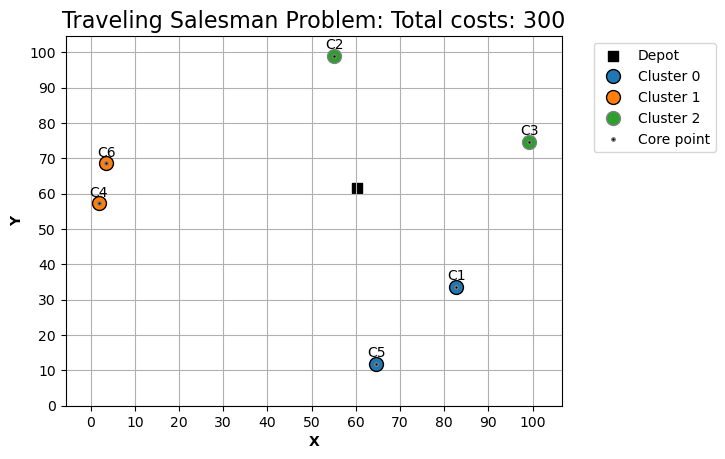

Cluster densities: {0: 0.0053, 1: 0.02, 2: 0.0013}


,1,2,3,4,5,6
1,0.000000,70.824715,44.140375,84.288881,28.377134,86.530513
2,70.824715,0.000000,50.367033,67.704954,87.656298,59.905424
3,44.140375,50.367033,0.000000,99.002385,71.714971,95.931370
4,84.288881,67.704954,99.002385,0.000000,77.594372,11.425156
5,28.377134,87.656298,71.714971,77.594372,0.000000,83.431673
6,86.530513,59.905424,95.931370,11.425156,83.431673,0.000000


In [10]:
# Define instance_id to recreate the TSP instance and have a deeper look into it
instance_id = 1
tsp_instance = instances[instance_id - 1]
num_customers = len(tsp_instance) - 1
coord = [(tsp_instance['X'][i], tsp_instance['Y'][i]) for i in range(len(tsp_instance))]
sequence, total_costs  = solve_tsp(coord)
X = coord[1:]

# Clustering the customers of the TSP instance
assignments, core_point_indices = fun_multi_dbscan(X=X, num_customers=num_customers, prints=True)

# View clusters
plot_tsp(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
         assignments=assignments, core_point_indices=core_point_indices, plot_sequence=False)

# Compute cluster densities
densities, area = cluster_density(X=X, assignments=assignments)

# Print cluster densities and view customer distances matrix as data frame
print('Cluster densities: {}'.format({key: np.round(densities[key], 4) for key in np.sort(list(densities.keys()))}))
pd.DataFrame(cdist(tsp_instance.iloc[1:][['X', 'Y']], tsp_instance.iloc[1:][['X', 'Y']], metric='euclidean'), index=np.arange(1, num_customers+1), columns=np.arange(1, num_customers+1))